In [1]:

############################################## 라이브러리 불러오기 #####################################################
# !pip install pycaret

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format #지수표현식말고 실수로 표현
import platform
import random
# import statsmodels
import math
# import missingno as msno
import scipy as sp
from scipy import stats
from scipy.stats import norm
from numpy.lib.shape_base import row_stack
import json
import re
import os
import zipfile
import warnings
warnings.filterwarnings(action = "ignore")

# 시각화
import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['axes.unicode_minus'] = False 
plt.style.use('seaborn')

plt.rcParams['axes.unicode_minus'] = False 

# 전처리
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# 학습데이터분리, 교차검증
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


In [2]:
############################# 피쳐 요약표 생성하는 함수 정의 #############################
def create_feature_info_df(data):
  
  print(f'데이터셋 shape: {data.shape}')
  summary = pd.DataFrame(data.dtypes, columns=['data_type']).reset_index()
  summary = summary.rename(columns={'index':'column'})
  summary['null_cnt'] = data.isnull().sum().values
  summary['unique_cnt'] = data.nunique().values
  return summary

In [20]:
############################# 연속형 target feature 시각화 (Histogram & QQ plot & Boxplot) #############################
def visualize_num_feature(df,col):

  nrows, ncols=1, 3
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5,nrows*4))

  sns.distplot(df[col],ax = ax[0]) # Histogram
  stats.probplot(df[col], plot=ax[1])  # QQ plot
  ax[1].set_title(' ')
  sns.boxplot(df[col],ax = ax[2])  # Boxplot
  title_font = {
    'fontsize': 14,
    'fontweight': 'bold'
}

  plt.suptitle(f'[ {col} ]',fontdict=title_font)
  plt.tight_layout()    
  plt.show()

In [3]:
############################ 범주형 target feature 시각화 (Count Plot & Pie Chart) #############################
def visualize_cat_feature(df,col):
  if len(df[col].unique().tolist()) <=10:
    nrows, ncols=1, 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5,nrows*4))

    # Count Plot
    sns.countplot(data = df, x=col,ax=ax[0],order=df[col].value_counts().index) 
    
    # Pie Chart
    for p in ax[0].patches:
      height = p.get_height()
      ax[0].text(p.get_x() + p.get_width() / 2., height+1, height, ha = 'center', size = 12)
    ax[1].pie(df[col].value_counts(), labels =df[col].unique().tolist(),  autopct = "%.f%%", shadow = True)


    ax[1].set_title(' ')


    title_font = {'fontsize': 14,
                  'fontweight': 'bold'}
    plt.suptitle(f'[ {col} ]',fontdict=title_font)
    plt.tight_layout()    
    plt.show()

In [4]:
############################################## 함수 정의(모델학습,검증,시각화 등을 위한) #####################################################

# 전체 데이터셋 히트맵으로 시각화 
def draw_corrmap(df):
  plt.figure(figsize=(10, 8))
  y_corrmat = df.corr()
  sns.heatmap(y_corrmat, #데이터
              annot = True, #셀값 표기 유무
              annot_kws = {"size": 10}, #셀값 글자크기
              cmap = 'PuBu', #히트맵 색
              cbar = True, #colorbar 유무
              linewidth=3,
              fmt='.2f') # 선굵기


# 특정 컬럼을 기준으로 상관관계가 가장 강한 top n 개를 히트맵으로 시각화 하는 함수 (# df = 데이터프레임 # y = 주요하게 보고 싶은 값 # k = 그 y값으로부터 가장 상관관계가 강한 TOP k개를 보겠다)
def draw_top_corrmap(df,y,k):
  plt.figure(figsize=(8, 6))
  y_corrmat = df.corr()
  y_cols = y_corrmat.nlargest(k, y)[y].index
  cm = np.corrcoef(df[y_cols].values.T)
  hm = sns.heatmap(cm, #데이터
                   annot = True, #셀값 표기 유무
                   annot_kws = {"size": 10}, #셀값 글자크기
                   cmap = 'PuBu', #히트맵 색
                   cbar = True, #colorbar 유무
                   linewidth=3, 
                   fmt='.2f',
                   yticklabels=y_cols.values, 
                   xticklabels=y_cols.values) # 선굵기
  

In [5]:
############################## 데이터 정보 확인하는 클래스 생성  ##############################

def print_data(data):
    print(f"\n##############################  데이터 확인 ##############################\n")
    print(f' *데이터 타입 : {type(data)}')
    print(f' *데이터 크기 : {data.shape}')
    print(f' *데이터 출력 : {data.head(10)}')

  
# 데이터 정보 확인하는 함수
def print_data_info(data):
    print(f"\n##############################  데이터 정보확인 ##############################\n")
    try:
      # feature 결측치갯수, 데이터 타입 확인 
      print(f"\n###  feature 결측치갯수, 데이터 타입 확인  ###\n")
      print(data.info(verbose=True))

    except:
      print(f"{data.name} 컬럼 타입: {data.dtypes}" )
      
    # feature 별 유일한 값 개수 확인
    print(f"\n###   feature 별 유일한 값 개수 확인  ###\n")
    [print(f"{col} : {len(data[col].unique())}") for col in data]


# 통계값 확인하는 함수
def print_data_describe(data):
    print(f"\n############################## 데이터 통계확인 ##############################\n")
    print(data.describe())

  
# 결측값 확인하는 함수
def print_missing_value(data):
  print(f"\n############################## 결측값 확인 ##############################\n")
  
  
  try:
    nan_cnt = pd.DataFrame(data=data.isnull().sum()/len(data),columns=['NaN_cnt'])
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    percent_data = percent.head(20)
    percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
    plt.xlabel("", fontsize = 20)
    plt.ylabel("", fontsize = 20)
    plt.title(f" Total Mbv issing Value (%)", fontsize = 20)
    print(f"\n#####  컬럼별 결측값 비율 시각화 ######\n")
    plt.show()
    print(f"\n#####  컬럼별 결측값 갯수 ######\n")
    data.isnull().sum()

  except:
    print(f"\n#####  결측값 갯수: {data.isnull().sum()} 개 ######\n")
    print()




### **1-2. 데이터 불러오기**

### 1) Image 데이터 불러오기
---
Layer, 종, 횡, 종횡비, Contour

In [55]:
image_data_15_25 = pd.read_csv("C:/Users/Chaaaaabbo/Desktop/3DP/2210_3DPrint해커톤/데이터/0. img_info_15~25.csv",index_col=0)
print(image_data_15_25.shape)
print(image_data_15_25.info())
image_data_15_25

(413726, 7)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 413726 entries, 0.0 to nan
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   시편            413726 non-null  int64  
 1   Layer No.     413726 non-null  object 
 2   contours_임계값  413726 non-null  float64
 3   면적            413726 non-null  object 
 4   종             413726 non-null  object 
 5   횡             413726 non-null  object 
 6   종횡비           413726 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 25.3+ MB
None


,시편,Layer No.,contours_임계값,면적,종,횡,종횡비
0.000,18,18_0065_49.bmp,0.050,Img_error,Img_error,Img_error,Img_error
1.000,18,18_0080_69.bmp,0.050,1318,80.999,22.693,3.569
2.000,18,18_0058_110.bmp,0.050,1305.5,73.775,24.407,3.023
3.000,18,18_0105_286.bmp,0.050,2901,64.139,66.291,0.968
4.000,18,18_0124_158.bmp,0.050,8158.5,102.4,104.2,0.983
...,...,...,...,...,...,...,...
NaN,24,24_0304_275.bmp,0.050,421,20.299,28.073,0.723
NaN,24,24_0070_32.bmp,0.050,587,23.464,32.284,0.727
NaN,24,24_0138_329.bmp,0.050,2397.5,44.72,86.577,0.517
NaN,24,24_0235_130.bmp,0.050,1816,32.199,74.237,0.434


In [56]:
image_data_26_31 = pd.read_csv("C:/Users/Chaaaaabbo/Desktop/3DP/2210_3DPrint해커톤/데이터/1. img_info_26~31.csv",index_col=0)
print(image_data_26_31.shape)
print(image_data_26_31.info())
image_data_26_31.columns

(238245, 7)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 238245 entries, 0.0 to nan
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   시편            238245 non-null  int64  
 1   Layer No.     238245 non-null  object 
 2   contours_임계값  238245 non-null  float64
 3   면적            238245 non-null  object 
 4   종             238245 non-null  object 
 5   횡             238245 non-null  object 
 6   종횡비           238245 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 14.5+ MB
None


Index(['시편', 'Layer No.', 'contours_임계값', '면적', '종', '횡', '종횡비'], dtype='object')

In [57]:
# 총 데이터 합치기, column 변경
total_image_data = pd.concat([image_data_15_25,image_data_26_31])
total_image_data.columns = ['시편번호', 'Layer No.', 'contours_임계값', '면적', '종', '횡', '종횡비']
total_image_data


,시편번호,Layer No.,contours_임계값,면적,종,횡,종횡비
0.000,18,18_0065_49.bmp,0.050,Img_error,Img_error,Img_error,Img_error
1.000,18,18_0080_69.bmp,0.050,1318,80.999,22.693,3.569
2.000,18,18_0058_110.bmp,0.050,1305.5,73.775,24.407,3.023
3.000,18,18_0105_286.bmp,0.050,2901,64.139,66.291,0.968
4.000,18,18_0124_158.bmp,0.050,8158.5,102.4,104.2,0.983
...,...,...,...,...,...,...,...
NaN,29,29_0274_42.bmp,0.050,571,38.746,20.292,1.909
NaN,31,31_0106_216.bmp,0.050,64.5,9,9,1
NaN,29,29_0095_130.bmp,0.050,500,18.897,37.638,0.502
NaN,31,31_0261_164.bmp,0.050,1333,57.107,31.278,1.826


### 2) 기계적 데이터 
---
에너지 밀도

In [58]:
mechanic_data = pd.read_excel("C:/Users/Chaaaaabbo/Desktop/3DP/2210_3DPrint해커톤/데이터/2. 시편별_기계적데이터.xlsx")
for i in range(len(mechanic_data)):
    mechanic_data['시편번호'][i] = mechanic_data['시편번호'][i][:2]
# print(mechanic_data.shape)
# print(mechanic_data.info())
mechanic_data

,시편번호,레이저파워,스캔스피드,"yielding.stress\n(항복강도,Mpa)","tensile.stress\n(인장강도,Mpa)","elongation\n(인장율,%)","density\n(밀도, g/cm^3)","distortion.x\n(장축 변형량,mm)",specimen.position\n(적층 가공 위치),단면적\n(mm^2),최대하중\n(N),인장강도\n(MPa),항복하중\n(N),항복강도\n(MPa),최대변위\n(mm),에너지밀도
0,15,360,1300,414.930,526.260,23.800,7.940,0.000,15,25.000,13156.500,526.260,10373.350,414.930,8.520,69.231
1,17,264,700,482.970,618.900,34.600,7.810,0.180,1,26.460,16893.130,638.390,13850.750,523.420,12.430,94.286
2,18,312,700,625.850,795.830,34.600,7.710,0.190,2,18.790,11629.710,618.900,9075.560,482.970,11.340,111.429
3,19,360,700,768.910,935.890,36.500,7.790,0.180,3,26.380,17016.500,645.020,13827.530,524.140,12.490,128.571
4,20,408,700,477.210,623.110,36.500,7.810,0.180,4,27.910,17389.150,623.110,13317.540,477.210,12.470,145.714
5,21,264,900,492.490,624.570,36.500,7.820,0.150,5,28.100,17550.960,624.570,13839.470,492.490,12.760,73.333
6,22,312,900,465.910,581.000,36.500,7.770,0.190,6,27.430,15939.730,581.000,12782.080,465.910,12.220,86.667
7,23,360,900,468.000,594.820,36.500,7.880,0.180,7,27.200,16179.010,594.820,12729.700,468.000,12.650,100.000
8,24,408,900,526.560,643.130,34.600,7.800,0.150,8,26.980,17353.850,643.130,14208.540,526.560,12.440,113.333
9,25,264,1100,394.810,486.540,15.400,7.610,0.000,9,26.920,13097.370,486.540,10628.040,394.810,5.650,60.000


In [59]:
# 레이저파워, 스캔스피드, 에너지밀도로 축소
energy_data = pd.DataFrame(mechanic_data, columns=['시편번호', '레이저파워', '스캔스피드', '에너지밀도'])
energy_data = energy_data.astype({'시편번호':'int'})
energy_data

,시편번호,레이저파워,스캔스피드,에너지밀도
0,15,360,1300,69.231
1,17,264,700,94.286
2,18,312,700,111.429
3,19,360,700,128.571
4,20,408,700,145.714
5,21,264,900,73.333
6,22,312,900,86.667
7,23,360,900,100.000
8,24,408,900,113.333
9,25,264,1100,60.000


In [60]:
## 시편 데이터 통합
merge_data = pd.merge(total_image_data,energy_data, how='inner', on='시편번호')
print('없는 시편 => ',set(energy_data['시편번호'].unique()) - set(total_image_data['시편번호'].unique()))
merge_data

없는 시편 =>  set()


,시편번호,Layer No.,contours_임계값,면적,종,횡,종횡비,레이저파워,스캔스피드,에너지밀도
0,18,18_0065_49.bmp,0.050,Img_error,Img_error,Img_error,Img_error,312,700,111.429
1,18,18_0080_69.bmp,0.050,1318,80.999,22.693,3.569,312,700,111.429
2,18,18_0058_110.bmp,0.050,1305.5,73.775,24.407,3.023,312,700,111.429
3,18,18_0105_286.bmp,0.050,2901,64.139,66.291,0.968,312,700,111.429
4,18,18_0124_158.bmp,0.050,8158.5,102.4,104.2,0.983,312,700,111.429
...,...,...,...,...,...,...,...,...,...,...
651966,29,29_0312_171.bmp,0.050,322.5,12.854,36.865,0.349,264,1300,50.769
651967,29,29_0242_136.bmp,0.050,None,None,None,None,264,1300,50.769
651968,29,29_0205_37.bmp,0.050,582.5,26.879,30.358,0.885,264,1300,50.769
651969,29,29_0274_42.bmp,0.050,571,38.746,20.292,1.909,264,1300,50.769


In [61]:
merge_data.columns

Index(['시편번호', 'Layer No.', 'contours_임계값', '면적', '종', '횡', '종횡비', '레이저파워',
       '스캔스피드', '에너지밀도'],
      dtype='object')

In [62]:
# 사용데이터로 추리기
merge_data = pd.DataFrame(merge_data, columns= ['시편번호', 'Layer No.', '면적', '종', '횡', '종횡비', '레이저파워', '스캔스피드', '에너지밀도'])
merge_data

,시편번호,Layer No.,면적,종,횡,종횡비,레이저파워,스캔스피드,에너지밀도
0,18,18_0065_49.bmp,Img_error,Img_error,Img_error,Img_error,312,700,111.429
1,18,18_0080_69.bmp,1318,80.999,22.693,3.569,312,700,111.429
2,18,18_0058_110.bmp,1305.5,73.775,24.407,3.023,312,700,111.429
3,18,18_0105_286.bmp,2901,64.139,66.291,0.968,312,700,111.429
4,18,18_0124_158.bmp,8158.5,102.4,104.2,0.983,312,700,111.429
...,...,...,...,...,...,...,...,...,...
651966,29,29_0312_171.bmp,322.5,12.854,36.865,0.349,264,1300,50.769
651967,29,29_0242_136.bmp,None,None,None,None,264,1300,50.769
651968,29,29_0205_37.bmp,582.5,26.879,30.358,0.885,264,1300,50.769
651969,29,29_0274_42.bmp,571,38.746,20.292,1.909,264,1300,50.769


In [63]:
# 컬럼명 변경
merge_data = merge_data.rename(columns = {'시편번호':'item_no',
                       '면적':'area',
                       '종':'length',
                       '횡':'width',
                       '종횡비':'aspect_ratio',
                       '레이저파워':'lazer_power',
                       '스캔스피드':'scan_speed',
                       '에너지밀도':'energe_density'})
merge_data

,item_no,Layer No.,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
0,18,18_0065_49.bmp,Img_error,Img_error,Img_error,Img_error,312,700,111.429
1,18,18_0080_69.bmp,1318,80.999,22.693,3.569,312,700,111.429
2,18,18_0058_110.bmp,1305.5,73.775,24.407,3.023,312,700,111.429
3,18,18_0105_286.bmp,2901,64.139,66.291,0.968,312,700,111.429
4,18,18_0124_158.bmp,8158.5,102.4,104.2,0.983,312,700,111.429
...,...,...,...,...,...,...,...,...,...
651966,29,29_0312_171.bmp,322.5,12.854,36.865,0.349,264,1300,50.769
651967,29,29_0242_136.bmp,None,None,None,None,264,1300,50.769
651968,29,29_0205_37.bmp,582.5,26.879,30.358,0.885,264,1300,50.769
651969,29,29_0274_42.bmp,571,38.746,20.292,1.909,264,1300,50.769


In [78]:
### 결측값 확인
print('총 Image Error 데이터', len(merge_data[merge_data['area'] == 'Img_error']))
for i in set(merge_data['item_no'].unique()):
    print(f'시편 {i}의 Image Error 데이터', len(merge_data[(merge_data['area'] == 'Img_error') & (merge_data['item_no'] == i)]),'전체', len(merge_data[(merge_data['area'] == 'Img_error') & (merge_data['item_no'] == i)])/len(merge_data[merge_data['item_no'] == i]))


총 Image Error 데이터 8827
시편 15의 Image Error 데이터 5997 전체 0.24727857496288966
시편 17의 Image Error 데이터 56 전체 0.00167159189277932
시편 18의 Image Error 데이터 173 전체 0.0037688989586510393
시편 19의 Image Error 데이터 130 전체 0.002677927695952209
시편 20의 Image Error 데이터 97 전체 0.0019838835030883133
시편 21의 Image Error 데이터 127 전체 0.0032963039867109634
시편 22의 Image Error 데이터 200 전체 0.004263483265828182
시편 23의 Image Error 데이터 228 전체 0.0048
시편 24의 Image Error 데이터 137 전체 0.002778961033692367
시편 25의 Image Error 데이터 319 전체 0.010495147228162527
시편 26의 Image Error 데이터 179 전체 0.0037728690666891493
시편 27의 Image Error 데이터 246 전체 0.005557814829876643
시편 28의 Image Error 데이터 110 전체 0.002291953160811768
시편 29의 Image Error 데이터 85 전체 0.0034858923884514437
시편 30의 Image Error 데이터 351 전체 0.01059622641509434
시편 31의 Image Error 데이터 392 전체 0.009552587971537187


In [ ]:
print('총 Contour None 데이터 : ', len(merge_data[merge_data['면적'] == 'None']))
for i in set(total_image_data['시편번호'].unique()):
    print(f'시편 {i}의 Contour None 데이터', len(merge_data[(merge_data['면적'] == 'None') & (merge_data['시편번호'] == i)]), '전체',len(merge_data[(merge_data['면적'] == 'None') & (merge_data['시편번호'] == i)])/len(merge_data[merge_data['시편번호'] == i]))

총 Contour None 데이터 :  29971
시편 15의 Contour None 데이터 0 전체 0.0
시편 17의 Contour None 데이터 599 전체 0.017880063281693084
시편 18의 Contour None 데이터 1788 전체 0.0389525510870986
시편 19의 Contour None 데이터 1339 전체 0.027582655268307756
시편 20의 Contour None 데이터 821 전체 0.0167914263508815
시편 21의 Contour None 데이터 1290 전체 0.033482142857142856
시편 22의 Contour None 데이터 2071 전체 0.04414836921765082
시편 23의 Contour None 데이터 2224 전체 0.04682105263157895
시편 24의 Contour None 데이터 1097 전체 0.02225197265664618
시편 25의 Contour None 데이터 3425 전체 0.11268300707353184
시편 26의 Contour None 데이터 1917 전체 0.04040553073096703
시편 27의 Contour None 데이터 2803 전체 0.0633274592200985
시편 28의 Contour None 데이터 1023 전체 0.021315164395549445
시편 29의 Contour None 데이터 1335 전체 0.054749015748031496
시편 30의 Contour None 데이터 3950 전체 0.11924528301886793
시편 31의 Contour None 데이터 4289 전체 0.10451798420898722


In [64]:
# None, Image Error 제거
merge_data_1 = merge_data[(merge_data['area'] != 'None') & (merge_data['area'] != 'Img_error')] 
merge_data_1

,item_no,Layer No.,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
1,18,18_0080_69.bmp,1318,80.999,22.693,3.569,312,700,111.429
2,18,18_0058_110.bmp,1305.5,73.775,24.407,3.023,312,700,111.429
3,18,18_0105_286.bmp,2901,64.139,66.291,0.968,312,700,111.429
4,18,18_0124_158.bmp,8158.5,102.4,104.2,0.983,312,700,111.429
5,18,18_0144_338.bmp,2412,102.076,30.885,3.305,312,700,111.429
...,...,...,...,...,...,...,...,...,...
651965,29,29_0225_77.bmp,669.5,42.933,22.361,1.92,264,1300,50.769
651966,29,29_0312_171.bmp,322.5,12.854,36.865,0.349,264,1300,50.769
651968,29,29_0205_37.bmp,582.5,26.879,30.358,0.885,264,1300,50.769
651969,29,29_0274_42.bmp,571,38.746,20.292,1.909,264,1300,50.769


In [ ]:
for i in range(len(merge_data_1)):
    merge_data_1['layer_no'][i] = merge_data_1['Layer No.'][i][:-4]

In [102]:
# 범주형으로 형변환 ['Item_No', 'Layer No.', 'area', 'length', 'width', 'aspect_ratio', 'Lazer_power', 'Scan_speed', 'Energe_dense'])

to_cat_cols = ['area', 'length', 'width', 'aspect_ratio', 'lazer_power', 'scan_speed', 'energe_density']
merge_data_1[to_cat_cols] = merge_data_1[to_cat_cols].astype('float')
merge_data_1

,item_no,Layer No.,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
1,18,18_0080_69.bmp,1318.000,80.999,22.693,3.569,312.000,700.000,111.429
2,18,18_0058_110.bmp,1305.500,73.775,24.407,3.023,312.000,700.000,111.429
3,18,18_0105_286.bmp,2901.000,64.139,66.291,0.968,312.000,700.000,111.429
4,18,18_0124_158.bmp,8158.500,102.400,104.200,0.983,312.000,700.000,111.429
5,18,18_0144_338.bmp,2412.000,102.076,30.885,3.305,312.000,700.000,111.429
...,...,...,...,...,...,...,...,...,...
651965,29,29_0225_77.bmp,669.500,42.933,22.361,1.920,264.000,1300.000,50.769
651966,29,29_0312_171.bmp,322.500,12.854,36.865,0.349,264.000,1300.000,50.769
651968,29,29_0205_37.bmp,582.500,26.879,30.358,0.885,264.000,1300.000,50.769
651969,29,29_0274_42.bmp,571.000,38.746,20.292,1.909,264.000,1300.000,50.769


In [103]:
merge_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 613173 entries, 1 to 651970
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   item_no         613173 non-null  int64  
 1   Layer No.       613173 non-null  object 
 2   area            613173 non-null  float64
 3   length          613173 non-null  float64
 4   width           613173 non-null  float64
 5   aspect_ratio    613173 non-null  float64
 6   lazer_power     613173 non-null  float64
 7   scan_speed      613173 non-null  float64
 8   energe_density  613173 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 46.8+ MB


In [104]:
merge_data_1.to_csv('C:/Users/Chaaaaabbo/Desktop/3DP/2210_3DPrint해커톤/데이터/merge_data.csv',header= True, index=True)

In [6]:
merge_data_1 = pd.read_csv('C:/Users/Chaaaaabbo/Desktop/3DP/2210_3DPrint해커톤/데이터/merge_data.csv',index_col=0)
print(merge_data_1.shape)
print(merge_data_1.info())
merge_data_1.columns

(613173, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 613173 entries, 1 to 651970
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   item_no         613173 non-null  int64  
 1   Layer No.       613173 non-null  object 
 2   area            613173 non-null  float64
 3   length          613173 non-null  float64
 4   width           613173 non-null  float64
 5   aspect_ratio    613173 non-null  float64
 6   lazer_power     613173 non-null  float64
 7   scan_speed      613173 non-null  float64
 8   energe_density  613173 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 46.8+ MB
None


Index(['item_no', 'Layer No.', 'area', 'length', 'width', 'aspect_ratio',
       'lazer_power', 'scan_speed', 'energe_density'],
      dtype='object')

## 2. 데이터 분석
---


### 1) 시편별 데이터 분석

In [7]:
create_feature_info_df(merge_data_1)

데이터셋 shape: (613173, 9)


,column,data_type,null_cnt,unique_cnt
0,item_no,int64,0,16
1,Layer No.,object,0,613173
2,area,float64,0,16913
3,length,float64,0,71788
4,width,float64,0,75058
5,aspect_ratio,float64,0,4835
6,lazer_power,float64,0,4
7,scan_speed,float64,0,4
8,energe_density,float64,0,15


In [8]:
merge_data_1[merge_data_1['item_no'] == 17].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,32846.000,32846.000,32846.000,32846.000,32846.000,32846.000,32846.000,32846.000
mean,17.000,1324.984,64.263,26.989,2.476,264.000,700.000,94.286
std,0.000,571.167,17.931,8.015,0.668,0.000,0.000,0.000
min,17.000,0.000,0.707,0.447,0.185,264.000,700.000,94.286
25%,17.000,954.000,55.154,22.627,2.007,264.000,700.000,94.286
50%,17.000,1325.500,65.054,27.333,2.343,264.000,700.000,94.286
75%,17.000,1725.500,74.246,32.000,2.849,264.000,700.000,94.286
max,17.000,8020.000,168.261,114.942,8.667,264.000,700.000,94.286


### 2) 데이터 시각화 
---

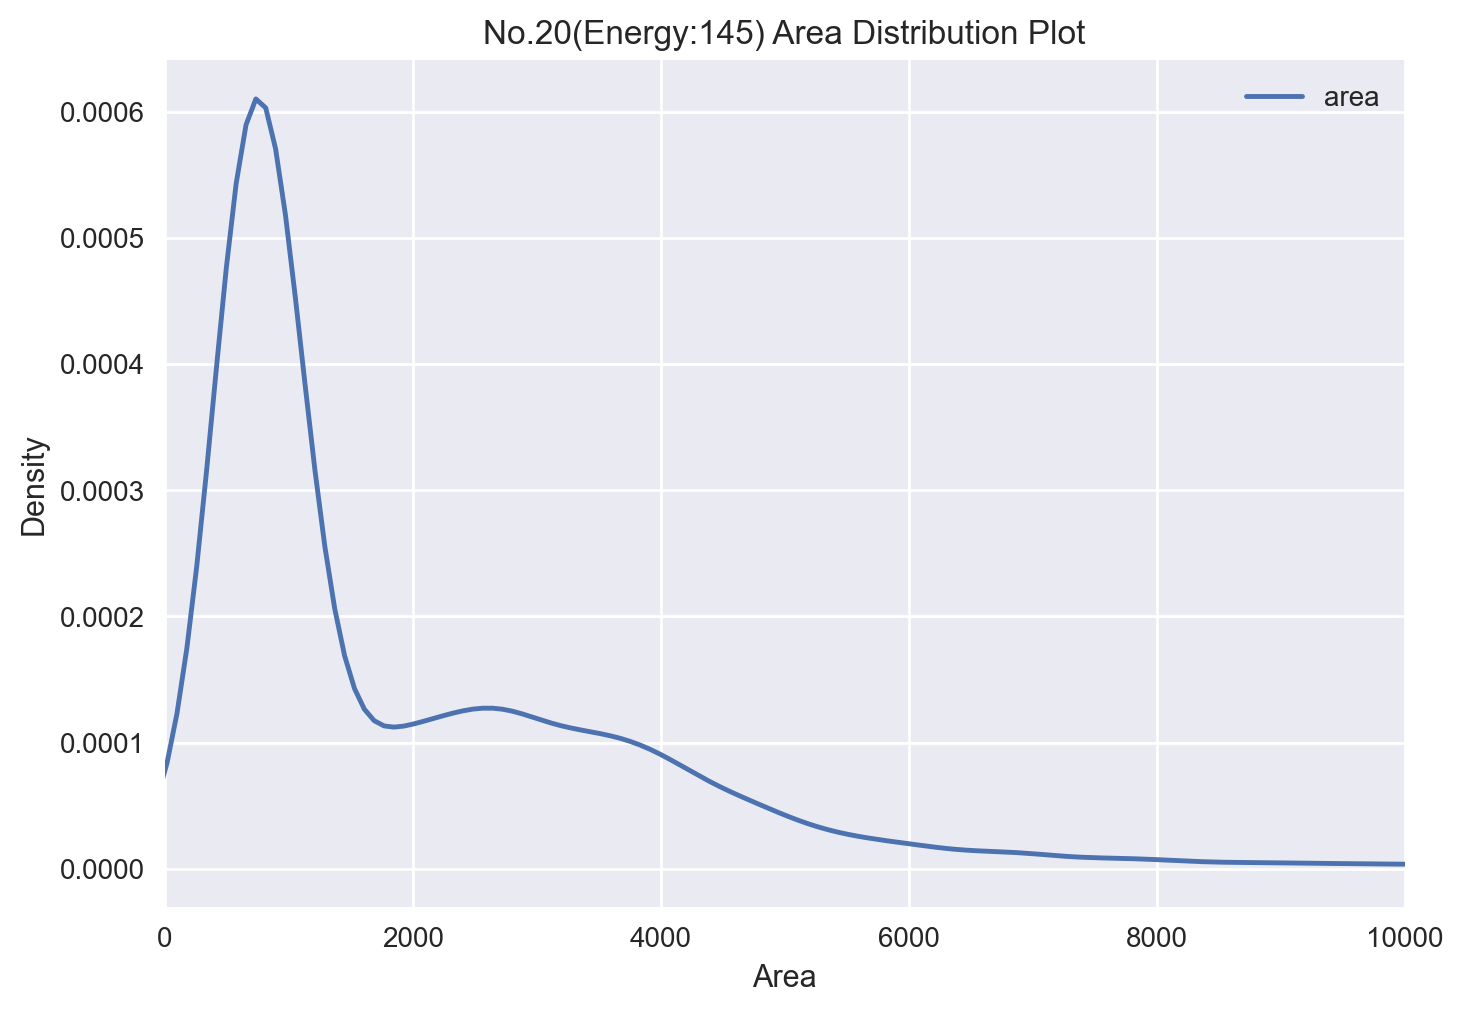

In [9]:
merge_data_1[(merge_data_1['item_no'] == 20)].plot.kde(y=['area'])
plt.xlim(0,10000)
plt.title("No.20(Energy:145) Area Distribution Plot")
plt.xlabel("Area")
plt.show()

In [10]:
merge_data_1[merge_data_1['item_no'] == 20].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,47976.000,47976.000,47976.000,47976.000,47976.000,47976.000,47976.000,47976.000
mean,20.000,2060.885,45.761,58.584,1.011,408.000,700.000,145.714
std,0.000,2131.820,25.947,33.997,0.834,0.000,0.000,0.000
min,20.000,0.000,0.447,0.707,0.125,408.000,700.000,145.714
25%,20.000,712.000,24.000,36.815,0.500,408.000,700.000,145.714
50%,20.000,1095.500,42.105,50.562,0.621,408.000,700.000,145.714
75%,20.000,2951.000,60.000,76.243,1.169,408.000,700.000,145.714
max,20.000,39715.000,247.896,250.000,9.667,408.000,700.000,145.714


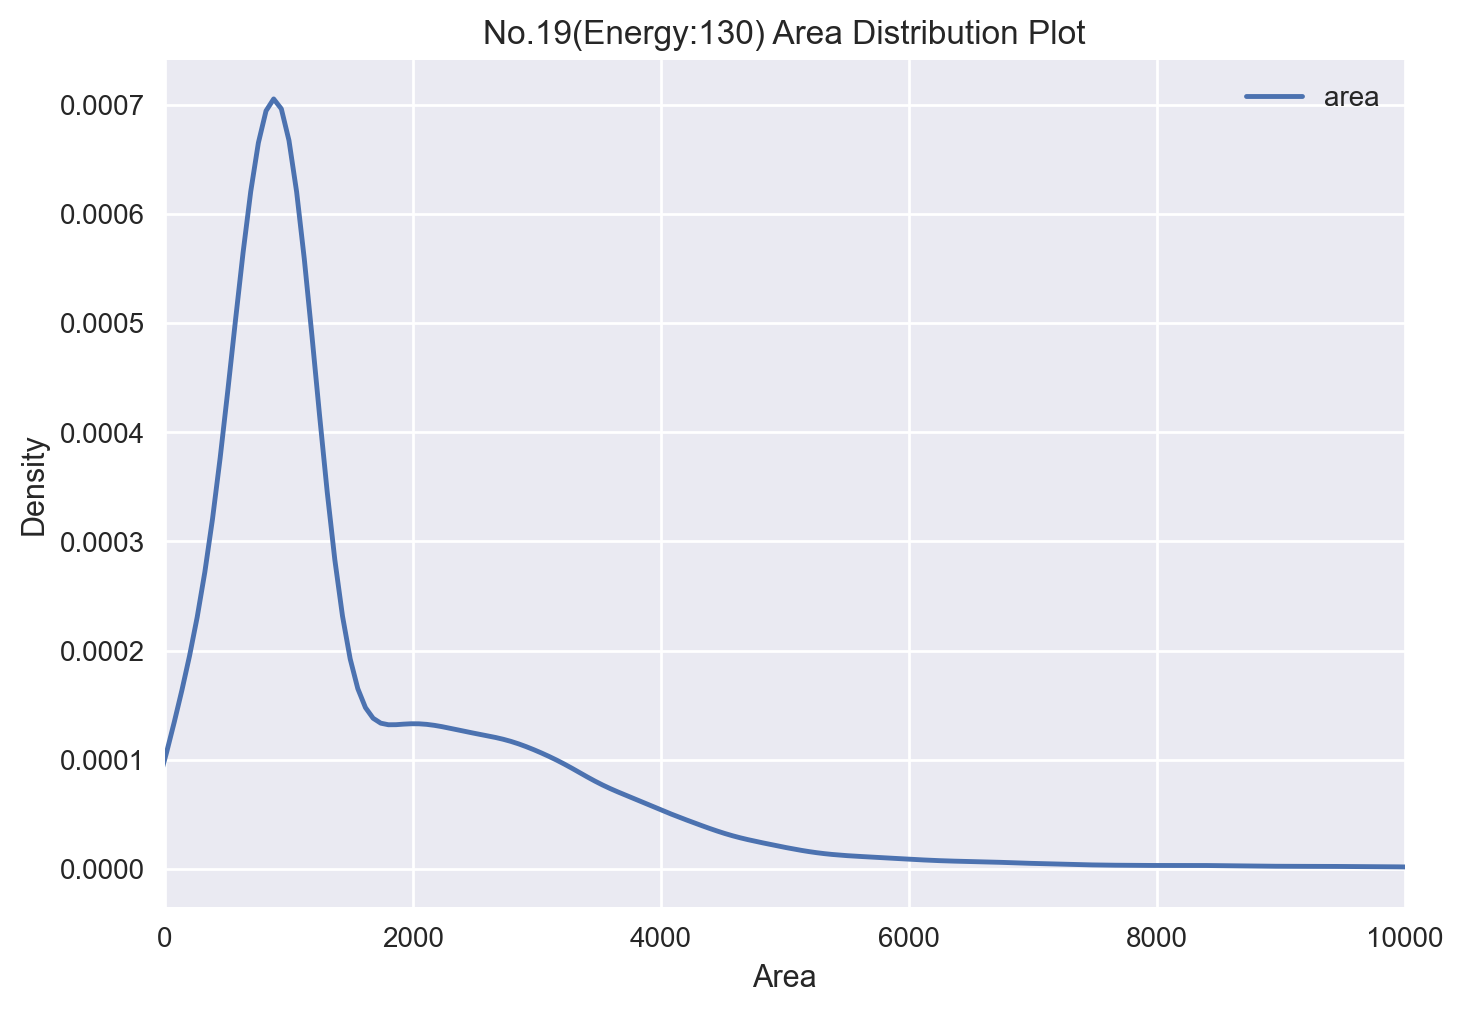

In [11]:
merge_data_1[(merge_data_1['item_no'] == 19)].plot.kde(y=['area'])
plt.xlim(0,10000)
plt.title("No.19(Energy:130) Area Distribution Plot")
plt.xlabel("Area")
plt.show()

In [12]:
merge_data_1[merge_data_1['item_no'] == 19].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,47076.000,47076.000,47076.000,47076.000,47076.000,47076.000,47076.000,47076.000
mean,19.000,1654.486,56.675,39.597,1.895,360.000,700.000,128.571
std,0.000,1674.228,25.040,26.965,0.979,0.000,0.000,0.000
min,19.000,0.000,0.447,0.447,0.113,360.000,700.000,128.571
25%,19.000,738.000,43.956,21.019,0.808,360.000,700.000,128.571
50%,19.000,1052.500,54.560,27.067,2.055,360.000,700.000,128.571
75%,19.000,2171.125,66.223,51.861,2.700,360.000,700.000,128.571
max,19.000,30811.000,266.431,230.866,8.362,360.000,700.000,128.571


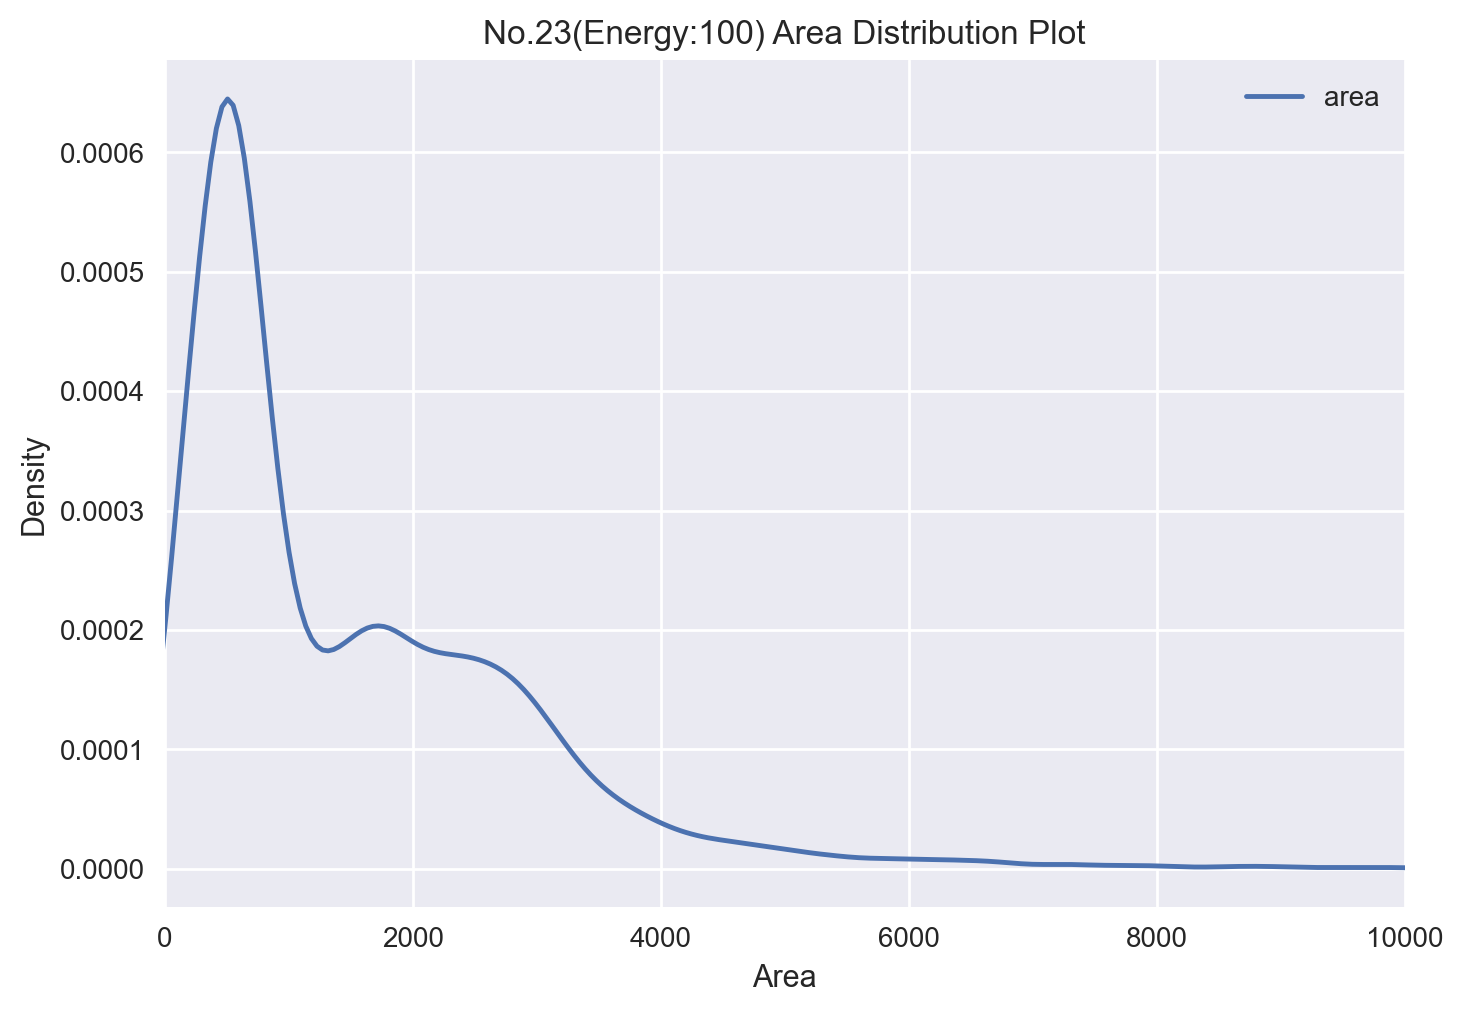

In [15]:
merge_data_1[(merge_data_1['item_no'] == 23)].plot.kde(y=['area'])
plt.xlim(0,10000)
plt.title("No.23(Energy:100) Area Distribution Plot")
plt.xlabel("Area")
plt.show()

In [14]:
merge_data_1[merge_data_1['item_no'] == 23].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,45048.000,45048.000,45048.000,45048.000,45048.000,45048.000,45048.000,45048.000
mean,23.000,1517.451,42.516,42.792,1.141,360.000,900.000,100.000
std,0.000,1449.051,21.213,24.489,0.534,0.000,0.000,0.000
min,23.000,0.000,0.447,0.447,0.111,360.000,900.000,100.000
25%,23.000,492.000,27.000,22.798,0.747,360.000,900.000,100.000
50%,23.000,960.500,40.305,36.000,1.000,360.000,900.000,100.000
75%,23.000,2274.000,53.442,59.927,1.461,360.000,900.000,100.000
max,23.000,22512.500,214.004,180.000,7.000,360.000,900.000,100.000


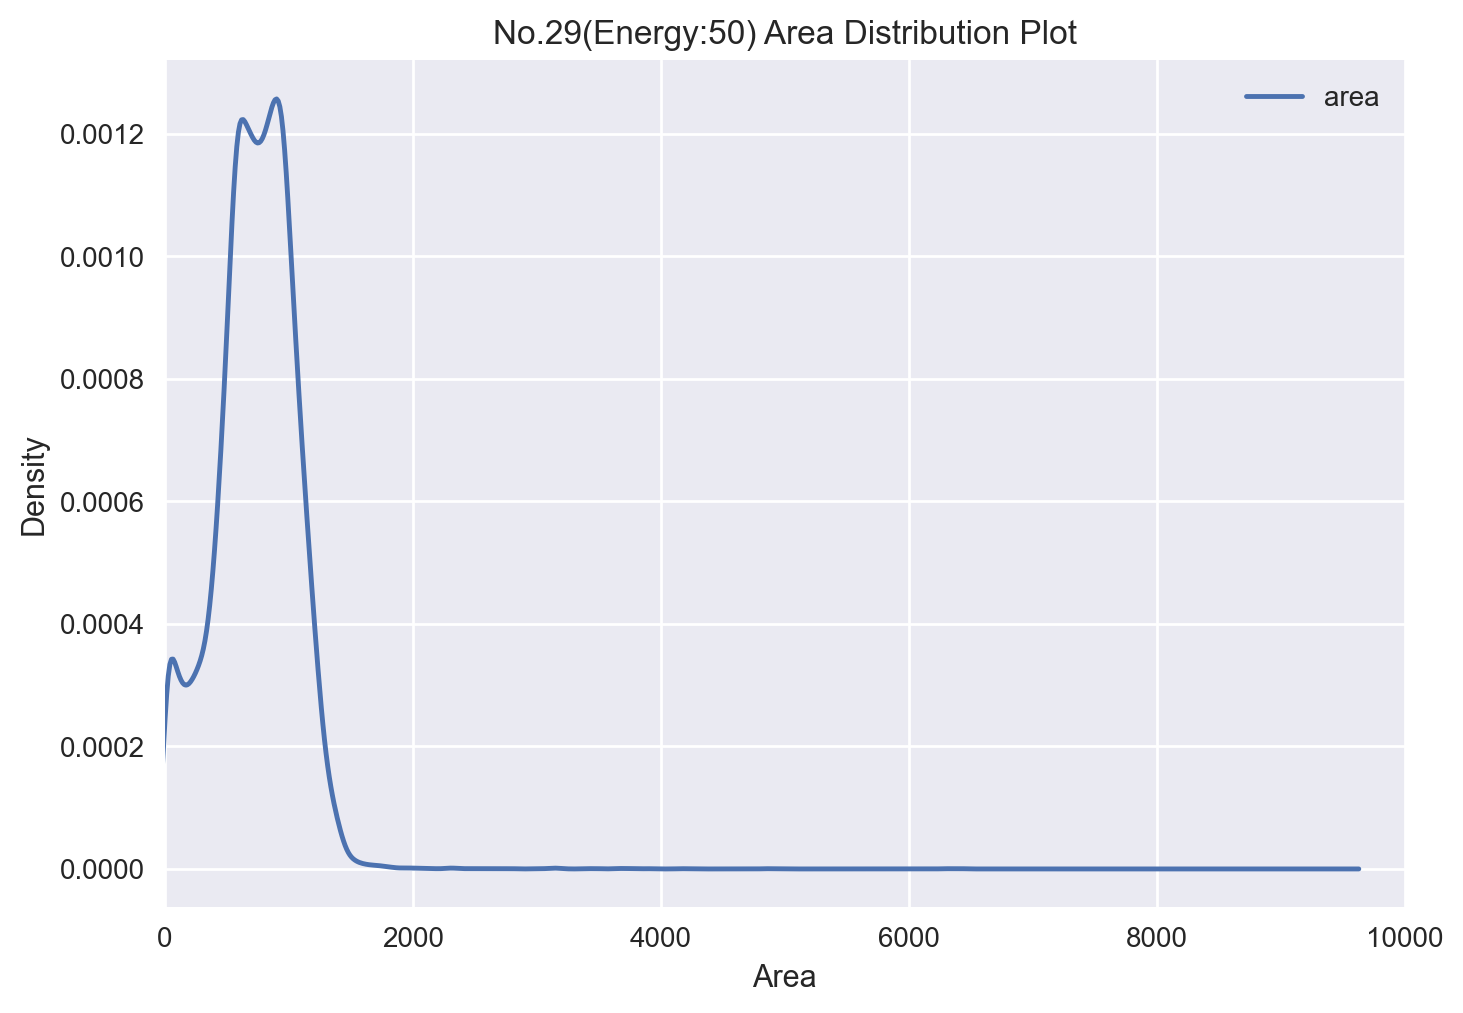

In [16]:
merge_data_1[(merge_data_1['item_no'] == 29)].plot.kde(y=['area'])
plt.xlim(0,10000)
plt.title("No.29(Energy:50) Area Distribution Plot")
plt.xlabel("Area")
plt.show()

In [17]:
merge_data_1[merge_data_1['item_no'] == 29].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,22964.000,22964.000,22964.000,22964.000,22964.000,22964.000,22964.000,22964.000
mean,29.000,732.368,36.544,27.130,1.403,264.000,1300.000,50.769
std,0.000,322.616,12.508,7.894,0.520,0.000,0.000,0.000
min,29.000,0.000,0.447,0.707,0.100,264.000,1300.000,50.769
25%,29.000,542.000,30.147,22.765,1.116,264.000,1300.000,50.769
50%,29.000,750.000,39.047,27.244,1.412,264.000,1300.000,50.769
75%,29.000,951.500,45.537,31.231,1.775,264.000,1300.000,50.769
max,29.000,6420.000,89.913,127.286,6.000,264.000,1300.000,50.769


In [18]:
# %%
visualize_cat_feature(merge_data_1, 'area')

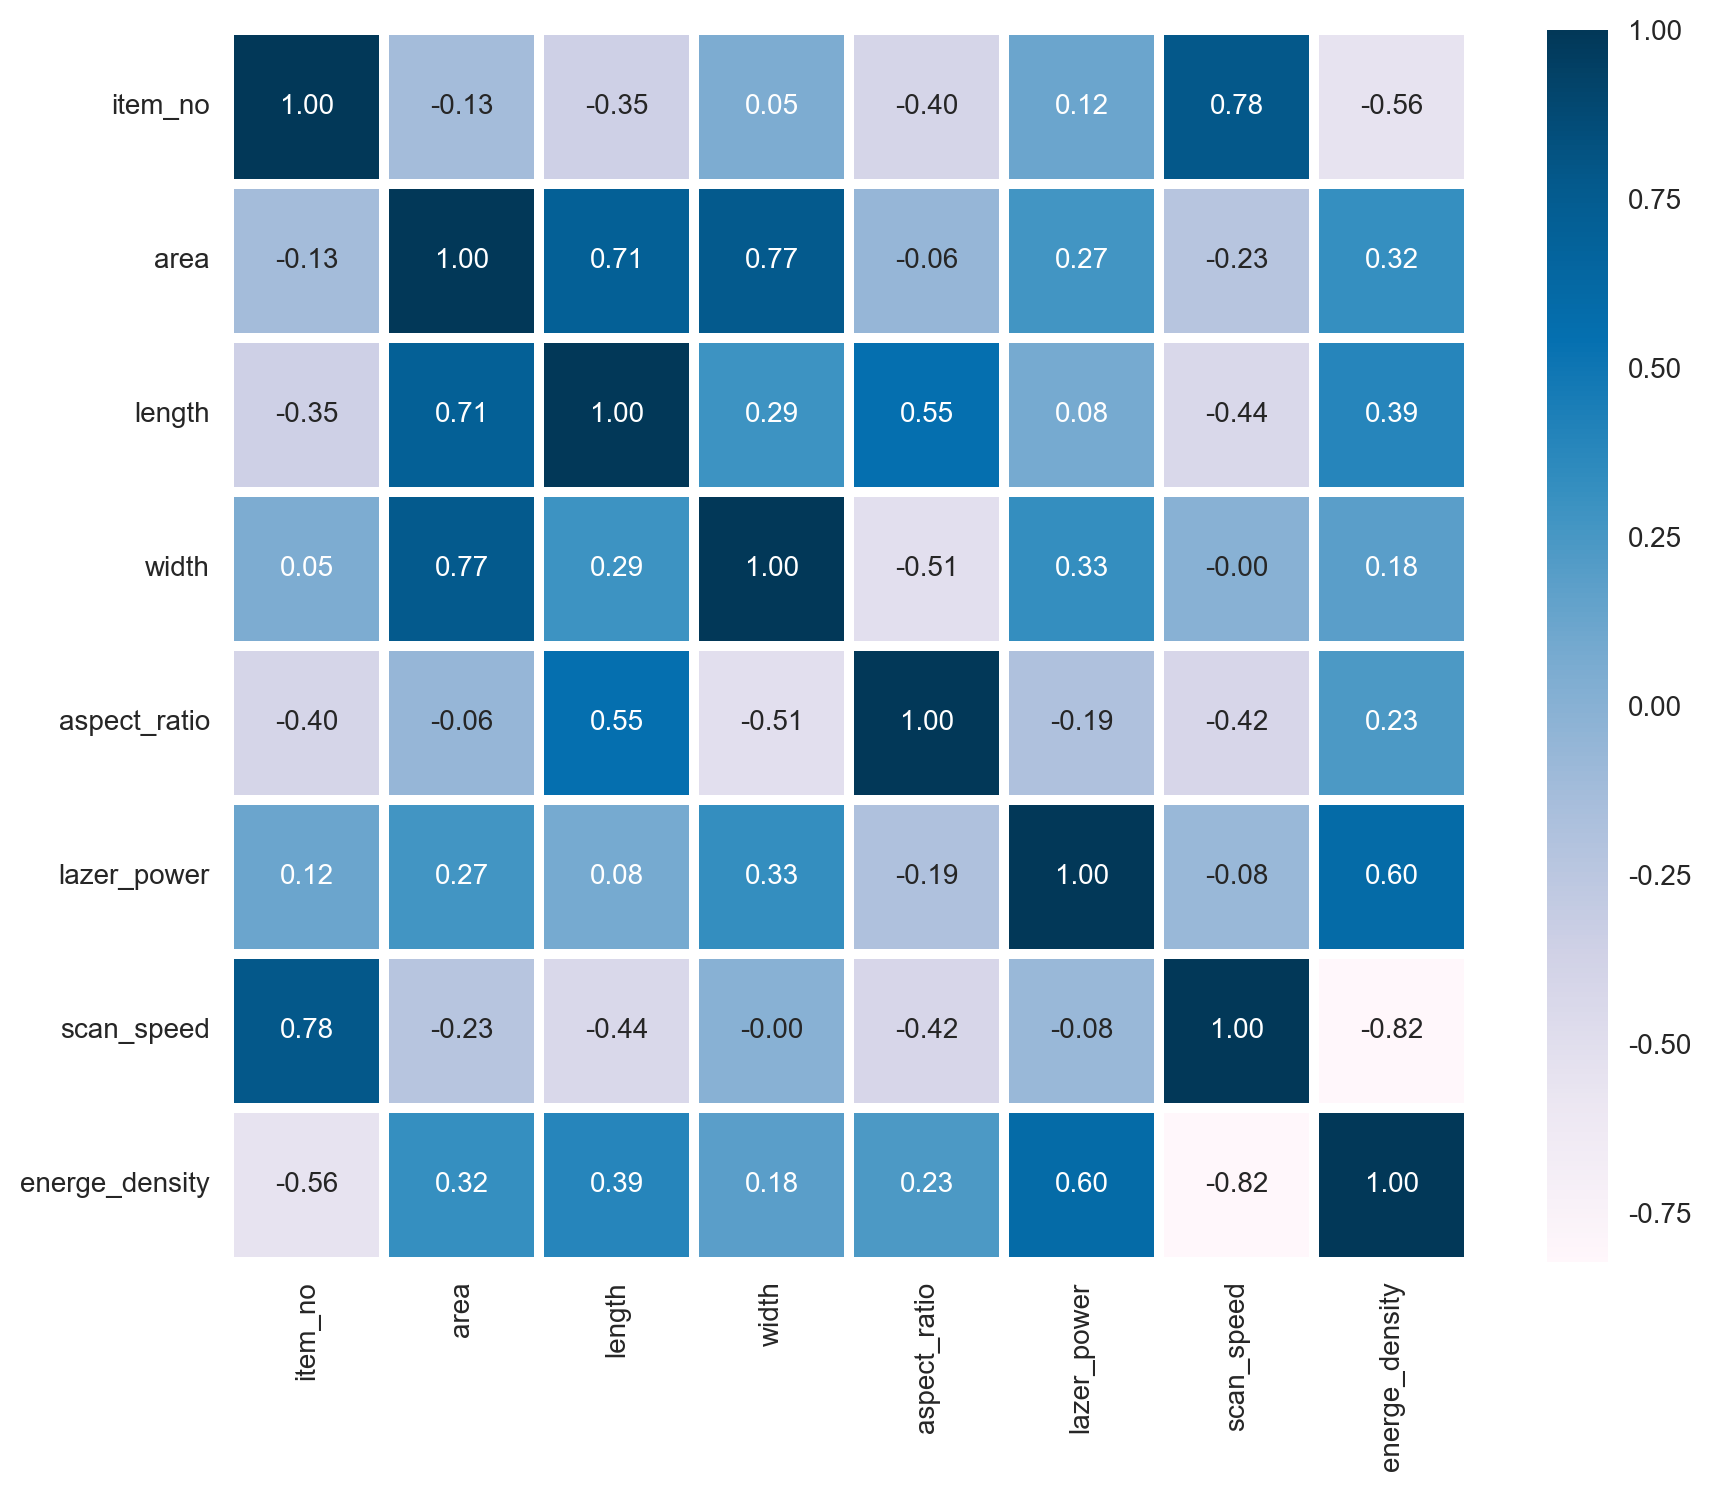

In [19]:
# %%
draw_corrmap(merge_data_1)

In [20]:
def boxplot(x, y, data):
    sns.boxplot(x=x, y=y, data=data)
    plt.title(f"{y} distribution by {x} / Box Plot")
    plt.show()

def boxplot_2(x, y, data):
    sns.boxplot(x=x, y=y, data=data)
    plt.ylim(0,4000)
    plt.title(f"{y} distribution by {x} / Box Plot")
    plt.show()

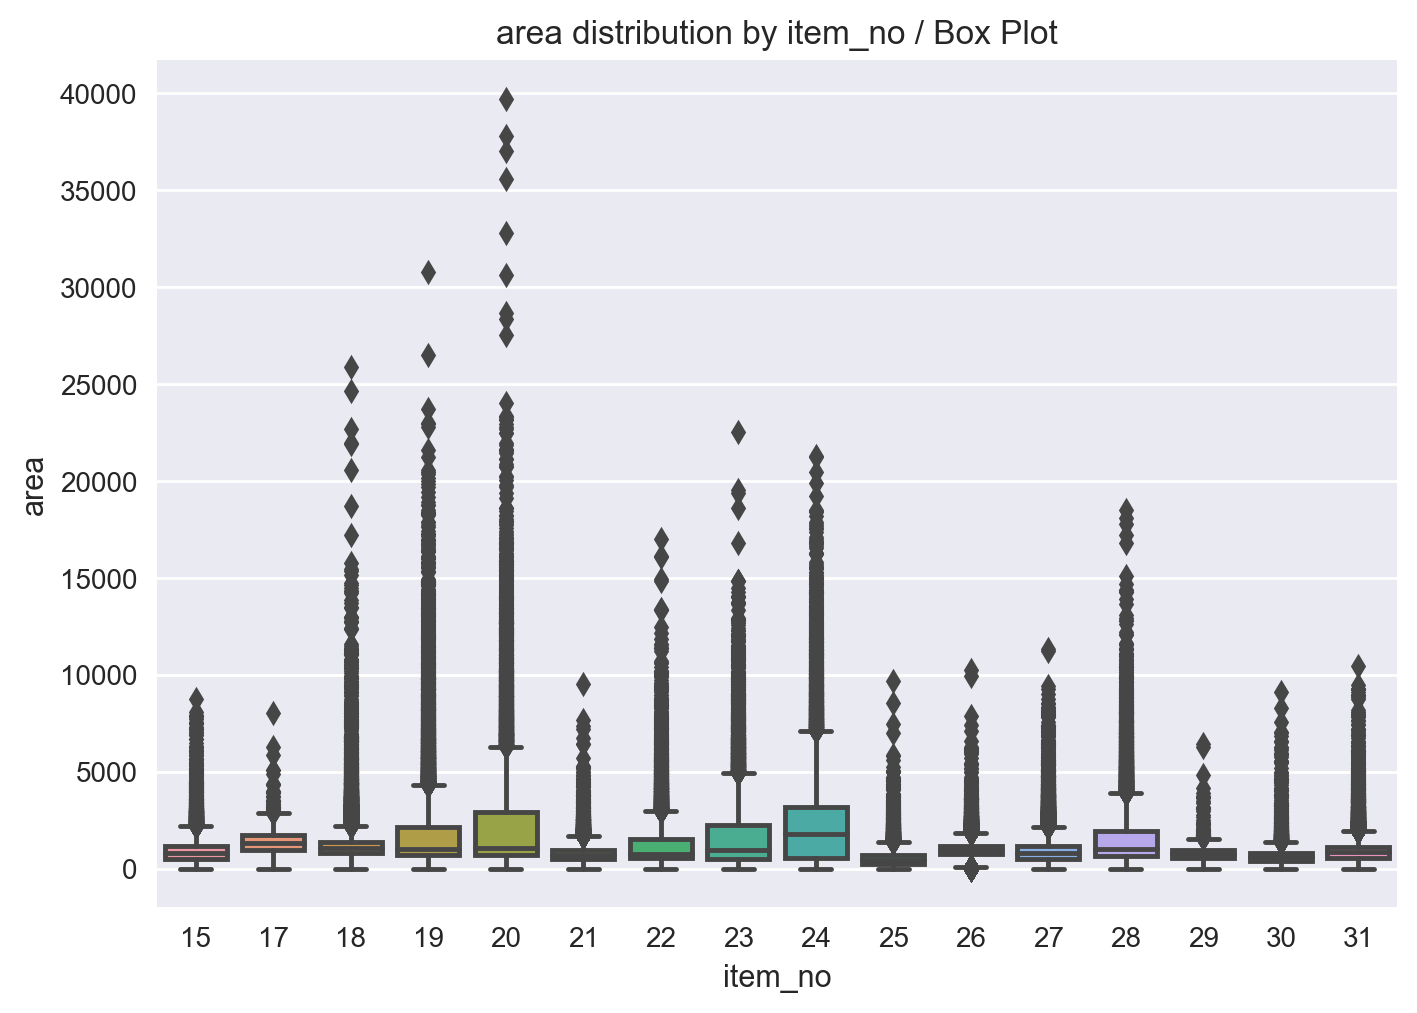

In [21]:
boxplot(x="item_no", y="area", data=merge_data_1)

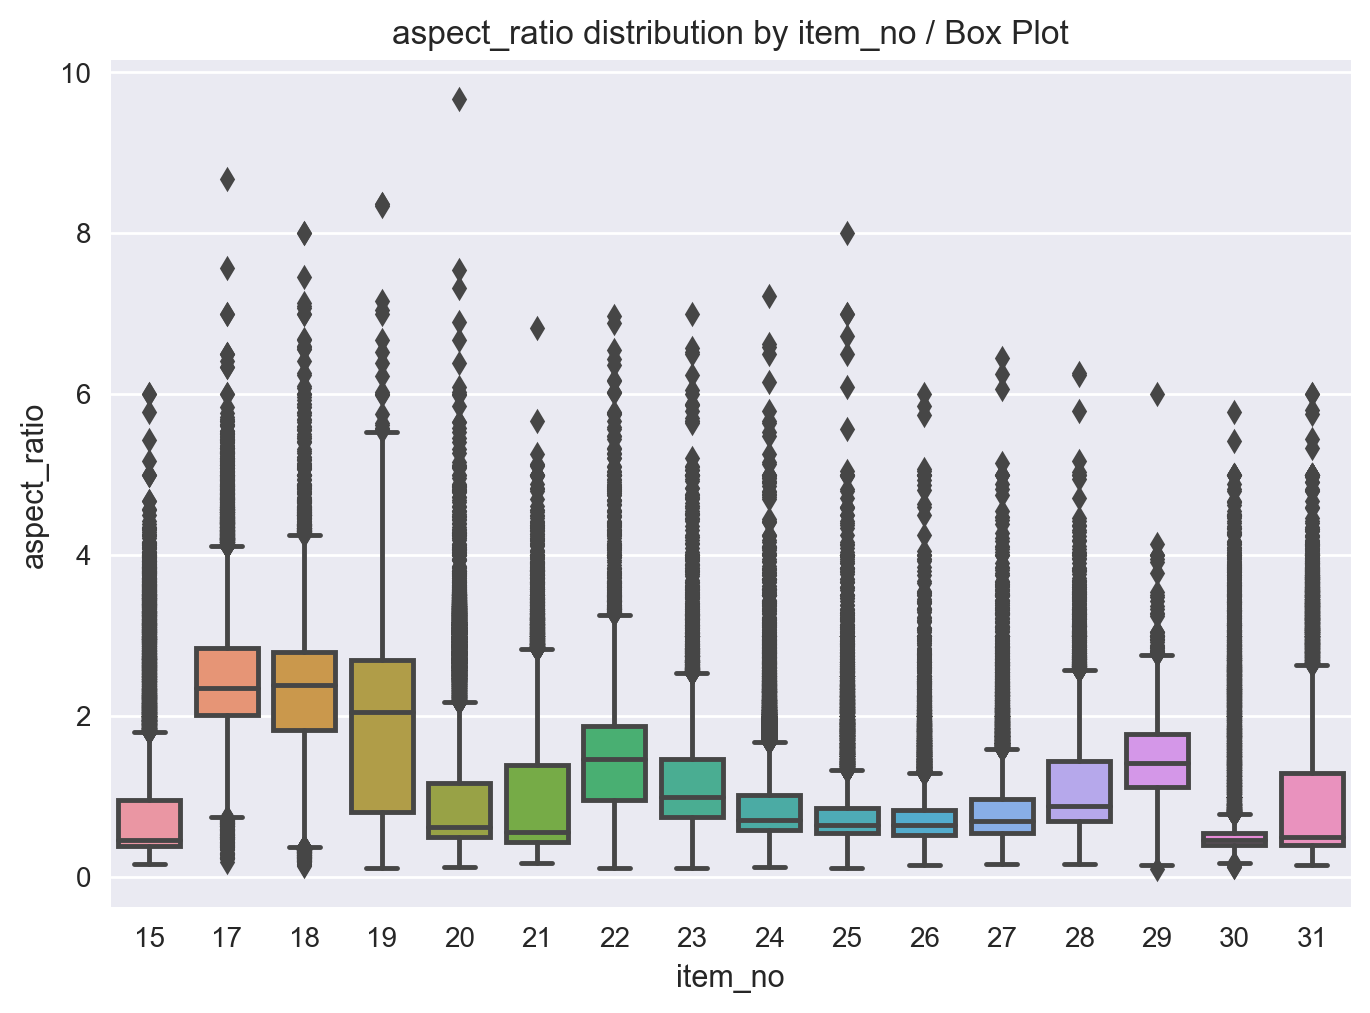

In [22]:
boxplot(x="item_no", y="aspect_ratio", data=merge_data_1)

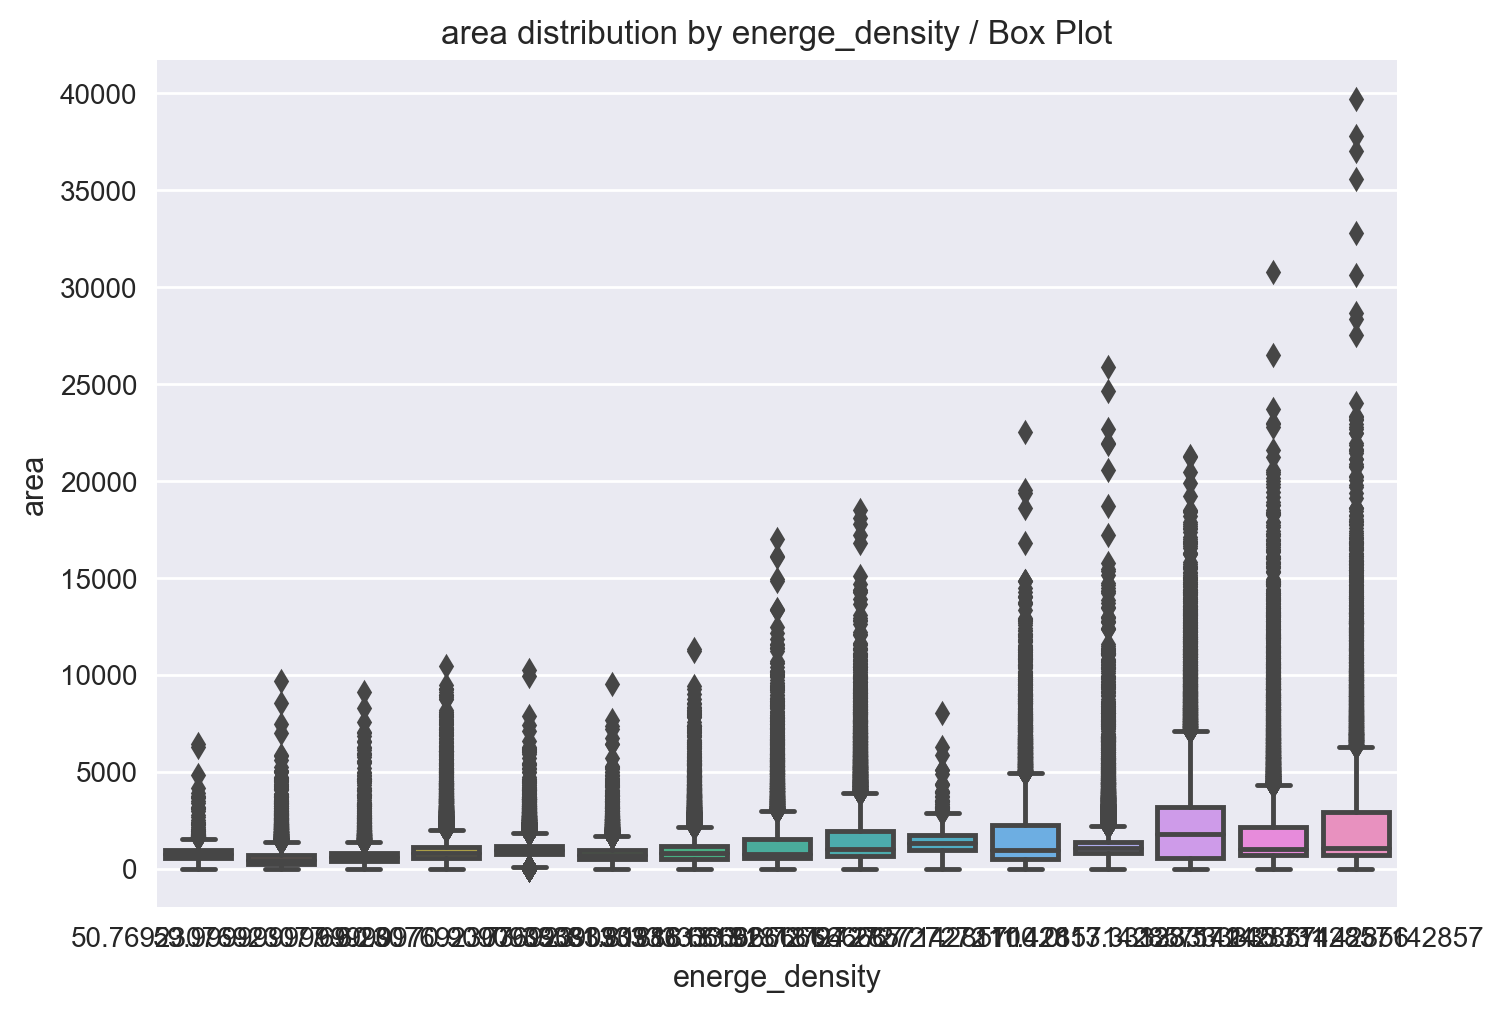

In [23]:
boxplot(x="energe_density", y="area", data=merge_data_1)

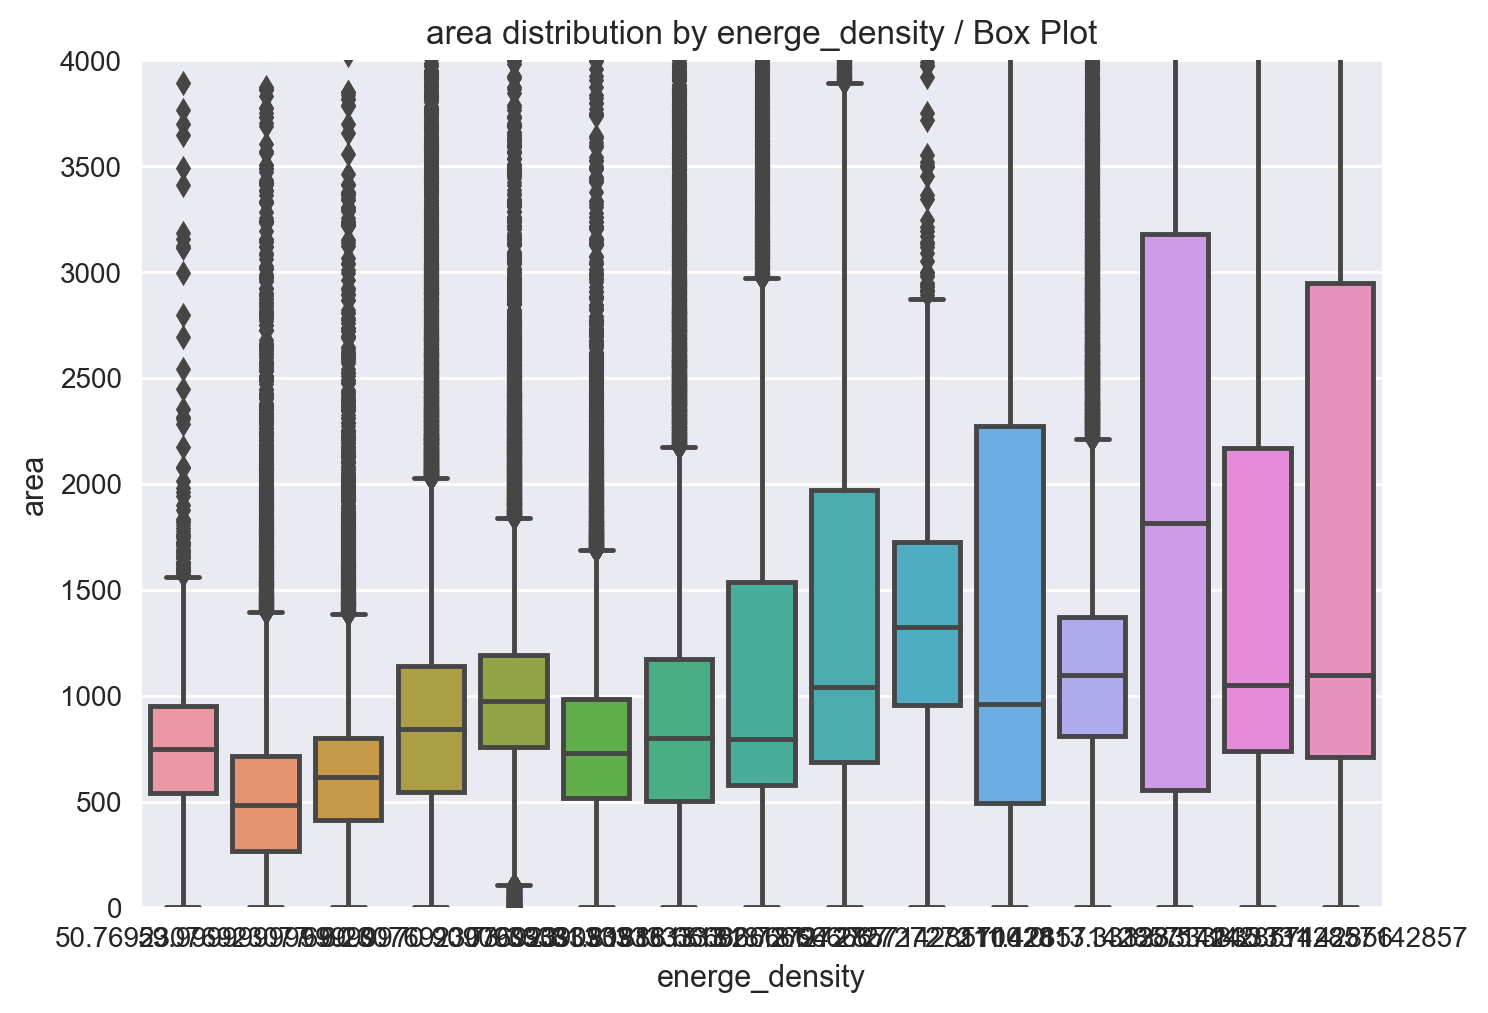

In [24]:
boxplot_2(x="energe_density", y="area", data=merge_data_1)

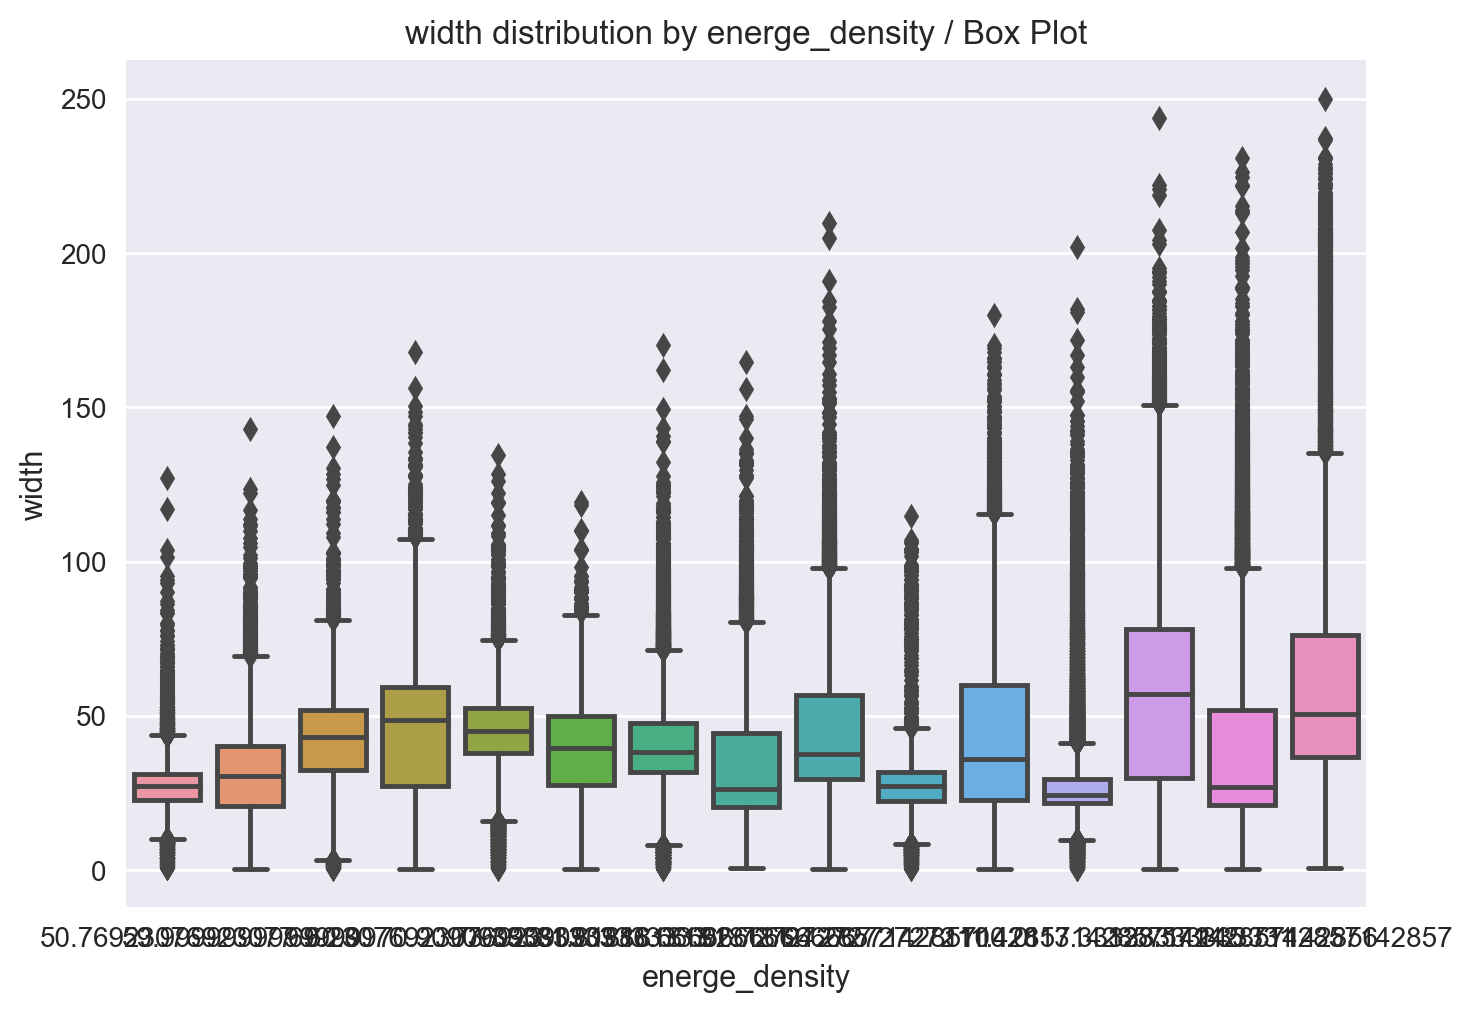

In [25]:
boxplot(x="energe_density", y="width", data=merge_data_1)

### Scan speed - Area 상관관계
---



700 -> 1601.307	
900 -> 1446.149
1100 -> 1059.150	
1300 -> 808.048

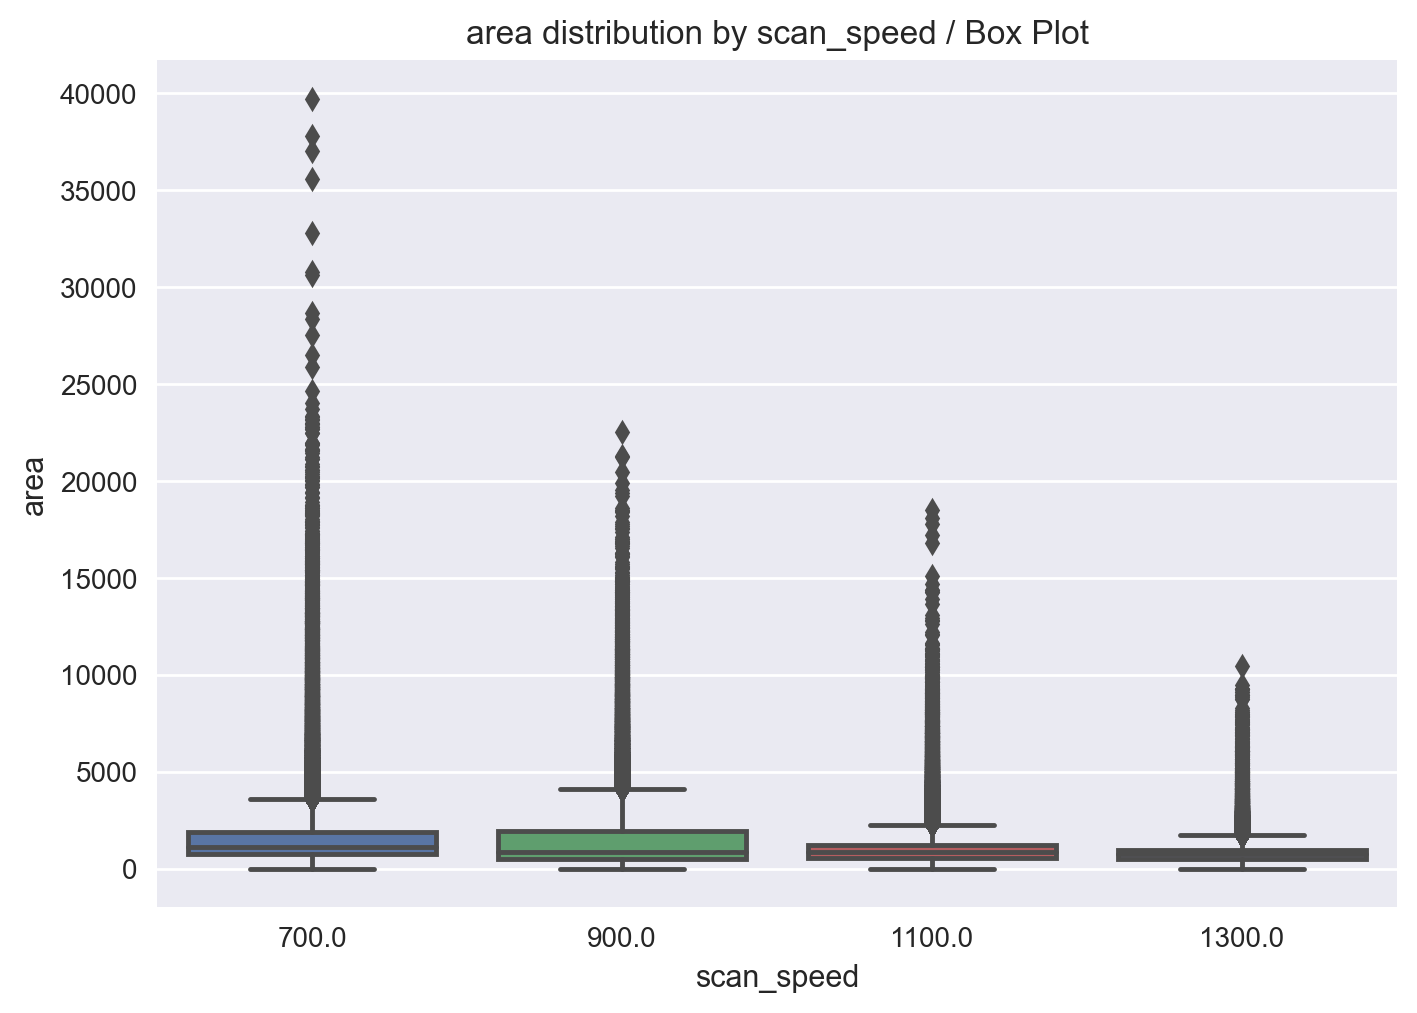

In [26]:
boxplot(x="scan_speed", y="area", data=merge_data_1)

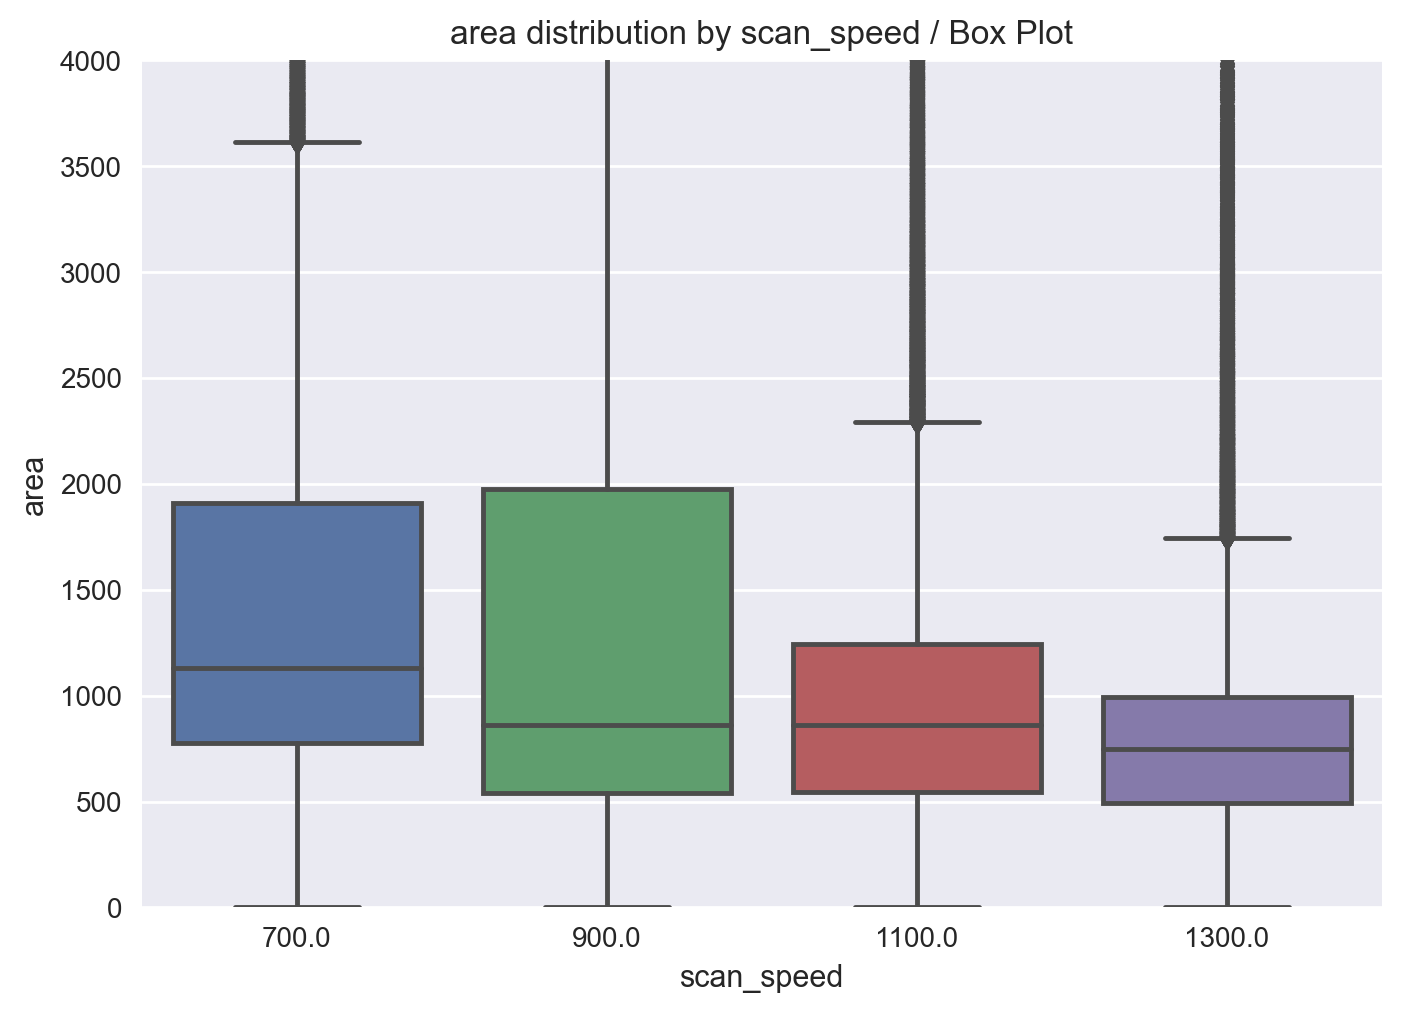

In [27]:
boxplot_2(x="scan_speed", y="area", data=merge_data_1)

In [28]:
merge_data_1[merge_data_1['scan_speed'] == 700.0].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,171839.000,171839.000,171839.000,171839.000,171839.000,171839.000,171839.000,171839.000
mean,18.641,1601.307,55.524,39.621,1.863,342.777,700.000,122.420
std,1.082,1562.977,23.501,27.466,1.010,51.936,0.000,18.549
min,17.000,0.000,0.447,0.447,0.113,264.000,700.000,94.286
25%,18.000,775.000,41.000,22.361,0.744,312.000,700.000,111.429
50%,19.000,1130.500,56.511,28.991,2.009,360.000,700.000,128.571
75%,20.000,1910.000,68.209,48.680,2.650,408.000,700.000,145.714
max,20.000,39715.000,266.431,250.000,9.667,408.000,700.000,145.714


In [29]:
merge_data_1[merge_data_1['scan_speed'] == 900.0].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,174863.000,174863.000,174863.000,174863.000,174863.000,174863.000,174863.000,174863.000
mean,22.595,1446.149,40.579,43.456,1.125,340.566,900.000,94.602
std,1.102,1476.991,20.891,25.186,0.648,52.912,0.000,14.698
min,21.000,0.000,0.447,0.447,0.111,264.000,900.000,73.333
25%,22.000,538.500,24.000,23.142,0.620,312.000,900.000,86.667
50%,23.000,862.500,38.716,38.321,0.923,360.000,900.000,100.000
75%,24.000,1975.000,51.400,57.426,1.541,408.000,900.000,113.333
max,24.000,22512.500,225.772,243.937,7.222,408.000,900.000,113.333


In [30]:
merge_data_1[merge_data_1['scan_speed'] == 1100.0].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,160073.000,160073.000,160073.000,160073.000,160073.000,160073.000,160073.000,160073.000
mean,26.676,1059.150,32.490,40.782,0.867,344.470,1100.000,78.289
std,1.066,916.738,16.120,17.004,0.457,51.190,0.000,11.634
min,25.000,0.000,0.447,0.447,0.113,264.000,1100.000,60.000
25%,26.000,546.000,22.579,30.316,0.564,312.000,1100.000,70.909
50%,27.000,859.500,29.172,39.383,0.723,360.000,1100.000,81.818
75%,28.000,1244.500,40.000,50.205,1.000,408.000,1100.000,92.727
max,28.000,18535.000,204.212,209.684,8.000,408.000,1100.000,92.727


In [31]:
merge_data_1[merge_data_1['scan_speed'] == 1300.0].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,106398.000,106398.000,106398.000,106398.000,106398.000,106398.000,106398.000,106398.000
mean,27.552,808.048,28.655,39.970,0.933,326.277,1300.000,62.746
std,5.759,573.013,14.589,18.671,0.739,38.419,0.000,7.388
min,15.000,0.000,0.447,0.447,0.100,264.000,1300.000,50.769
25%,29.000,495.000,19.606,25.456,0.411,312.000,1300.000,60.000
50%,30.000,748.000,23.476,39.728,0.536,360.000,1300.000,69.231
75%,31.000,994.000,38.450,53.957,1.370,360.000,1300.000,69.231
max,31.000,10480.500,174.882,168.000,6.000,360.000,1300.000,69.231


### Energy density - Area 상관관계

----
lazer power 별 Area mean 값 
비례하는 것은 보이나, 1차적으로 비례하진 않음 
['lazer_power'] == 264.0 -> 875.063  
['lazer_power'] == 312.0 -> 1036.329 (+161)  
['lazer_power'] == 360.0 -> 1263.106 (+227)  
['lazer_power'] == 408.0 -> 1909.464 (+646)


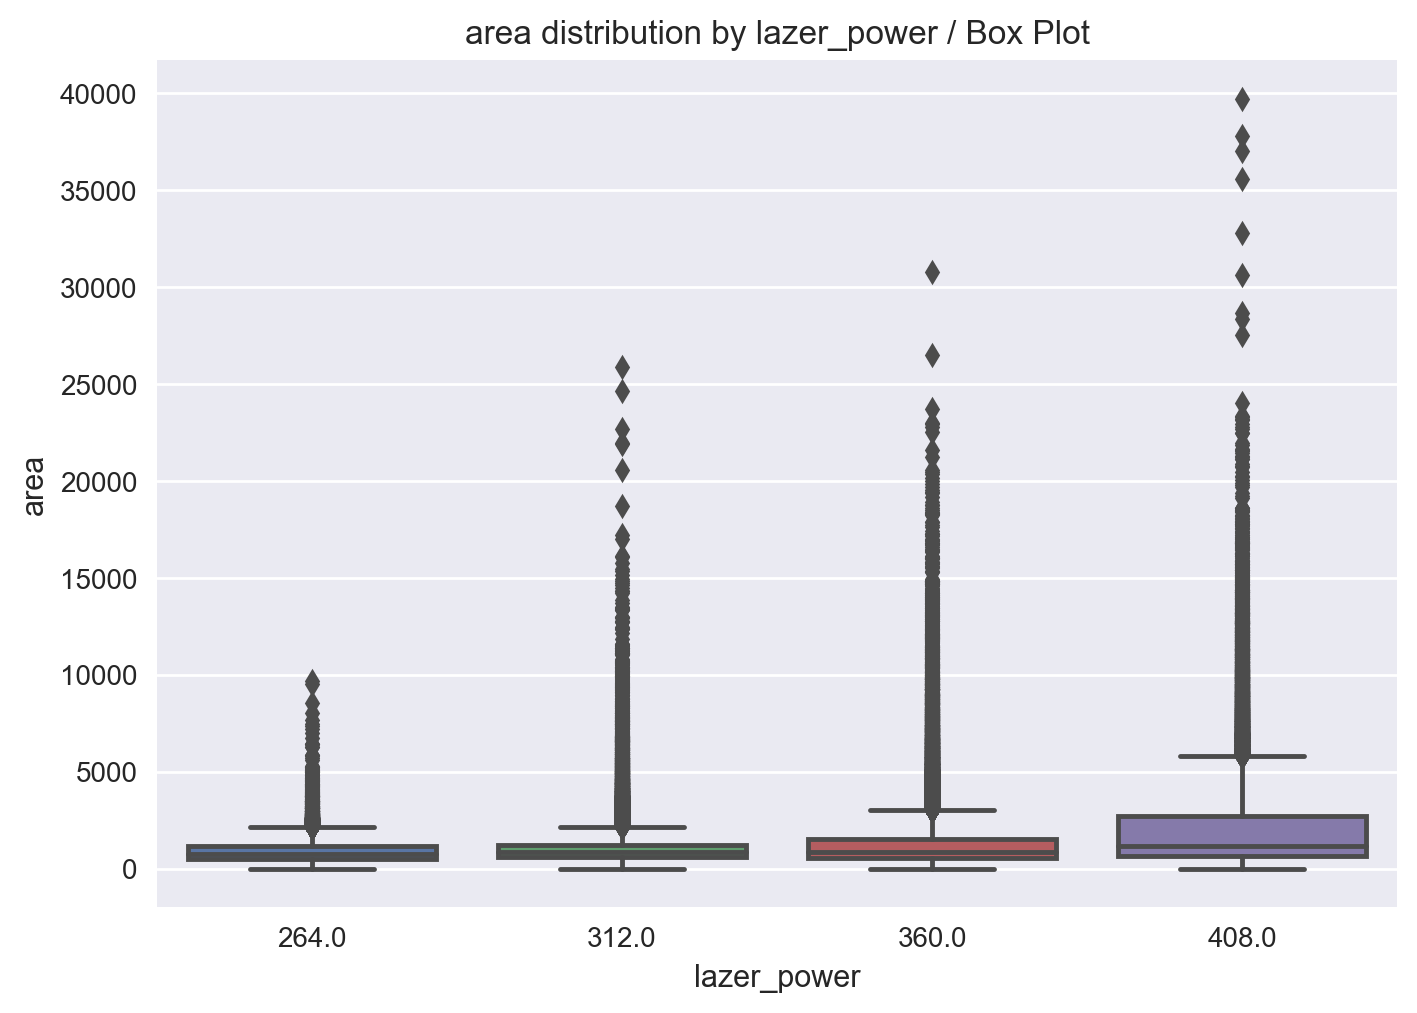

In [32]:
boxplot(x="lazer_power", y="area", data=merge_data_1)

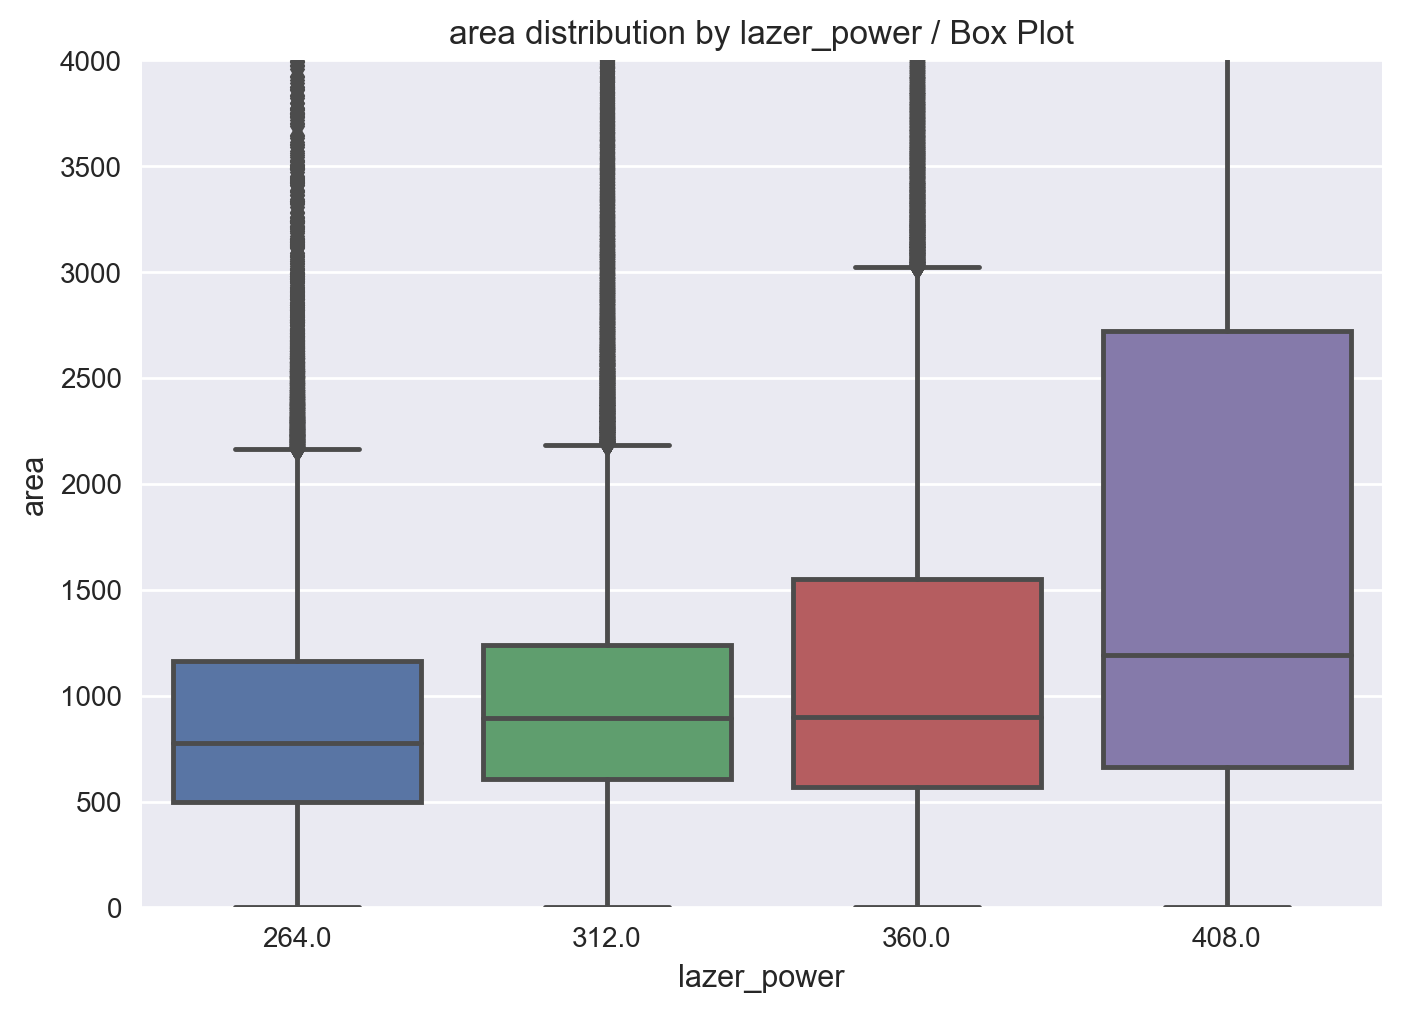

In [33]:
boxplot_2(x="lazer_power", y="area", data=merge_data_1)

In [34]:
merge_data_1[merge_data_1['lazer_power'] == 264.0].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,119572.000,119572.000,119572.000,119572.000,119572.000,119572.000,119572.000,119572.000
mean,22.329,875.063,38.854,31.431,1.433,264.000,966.459,71.784
std,4.300,553.148,21.871,12.669,0.925,0.000,214.977,15.987
min,17.000,0.000,0.447,0.447,0.100,264.000,700.000,50.769
25%,17.000,496.000,20.875,23.255,0.568,264.000,700.000,60.000
50%,21.000,777.500,35.693,29.725,1.293,264.000,900.000,73.333
75%,25.000,1163.000,53.570,38.637,2.089,264.000,1100.000,94.286
max,29.000,9668.000,168.261,143.136,8.667,264.000,1300.000,94.286


In [35]:
merge_data_1[merge_data_1['lazer_power'] == 312.0].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,162752.000,162752.000,162752.000,162752.000,162752.000,162752.000,162752.000,162752.000
mean,23.451,1036.329,39.654,36.424,1.347,312.000,972.571,84.239
std,4.243,794.555,19.695,16.651,0.901,0.000,212.168,18.835
min,18.000,0.000,0.447,0.447,0.111,312.000,700.000,60.000
25%,18.000,608.500,24.684,22.949,0.564,312.000,700.000,70.909
50%,22.000,896.500,35.742,35.392,1.003,312.000,900.000,86.667
75%,26.000,1239.500,52.547,48.191,2.017,312.000,1100.000,111.429
max,30.000,25869.000,231.534,202.000,8.000,312.000,1300.000,111.429


In [36]:
merge_data_1[merge_data_1['lazer_power'] == 360.0].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,187947.000,187947.000,187947.000,187947.000,187947.000,187947.000,187947.000,187947.000
mean,23.646,1263.106,39.522,41.890,1.185,360.000,1009.985,94.229
std,5.069,1256.611,22.548,22.453,0.845,0.000,230.615,22.776
min,15.000,0.000,0.447,0.447,0.111,360.000,700.000,69.231
25%,19.000,566.500,22.648,23.511,0.540,360.000,700.000,69.231
50%,23.000,897.500,35.089,39.182,0.856,360.000,1100.000,81.818
75%,27.000,1550.000,52.380,55.925,1.683,360.000,1300.000,128.571
max,31.000,30811.000,266.431,230.866,8.362,360.000,1300.000,128.571


In [37]:
merge_data_1[merge_data_1['lazer_power'] == 408.0].describe()

,item_no,area,length,width,aspect_ratio,lazer_power,scan_speed,energe_density
count,142902.000,142902.000,142902.000,142902.000,142902.000,142902.000,142902.000,142902.000
mean,23.969,1909.464,44.498,53.384,0.991,408.000,898.439,117.447
std,3.258,1875.624,23.758,30.155,0.634,0.000,162.923,21.779
min,20.000,0.000,0.447,0.447,0.118,408.000,700.000,92.727
25%,20.000,662.500,26.044,31.000,0.576,408.000,700.000,92.727
50%,24.000,1192.500,41.110,47.000,0.738,408.000,900.000,113.333
75%,28.000,2724.000,57.757,71.000,1.235,408.000,1100.000,145.714
max,28.000,39715.000,247.896,250.000,9.667,408.000,1100.000,145.714


### 회귀분석
---
- 참고 블로그 : [파이썬 데이터분석 회귀분석](https://no17.tistory.com/195)

In [38]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

In [39]:
model = smf.ols(formula = 'area ~ energe_density', data = merge_data_1)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                 7.136e+04
Date:                Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:36:57   Log-Likelihood:            -5.2294e+06
No. Observations:              613173   AIC:                         1.046e+07
Df Residuals:                  613171   BIC:                         1.046e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -225.3366      5.840    -38.585      0.000    -236.783    -213.890
energe_density    16.2314      0.061    267.136      0.000      16.112      16.351
==============================================================================
Omnibus:                   520378.222   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         30375418.308
Skew:                           3.773   Prob(JB):                         0.00
Kurtosis:                      36.645   Cond. No.                         359.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
model = smf.ols(formula = 'area ~  scan_speed', data = merge_data_1)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                 3.312e+04
Date:                Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                        17:22:14   Log-Likelihood:            -5.2470e+06
No. Observations:              613173   AIC:                         1.049e+07
Df Residuals:                  613171   BIC:                         1.049e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2608.1869      7.485    348.456      0.000    2593.517    2622.857
scan_speed    -1.3777      0.008   -181.980      0.000      -1.393      -1.363
==============================================================================
Omnibus:                   530512.087   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29334010.947
Skew:                           3.918   Prob(JB):                         0.00
Kurtosis:                      35.966   Cond. No.                     4.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
model = smf.ols(formula = 'area ~  lazer_power', data = merge_data_1)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                 4.887e+04
Date:                Mon, 30 Jan 2023   Prob (F-statistic):               0.00
Time:                        17:22:42   Log-Likelihood:            -5.2396e+06
No. Observations:              613173   AIC:                         1.048e+07
Df Residuals:                  613171   BIC:                         1.048e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1092.3376     10.838   -100.783      0.000   -1113.581   -1071.094
lazer_power     6.9769      0.032    221.073      0.000       6.915       7.039
==============================================================================
Omnibus:                   521555.025   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         29983311.584
Skew:                           3.793   Prob(JB):                         0.00
Kurtosis:                      36.407   Cond. No.                     2.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
merge_data_1['area'].mean()

1277.8789852129823

<AxesSubplot: xlabel='energe_density', ylabel='area'>

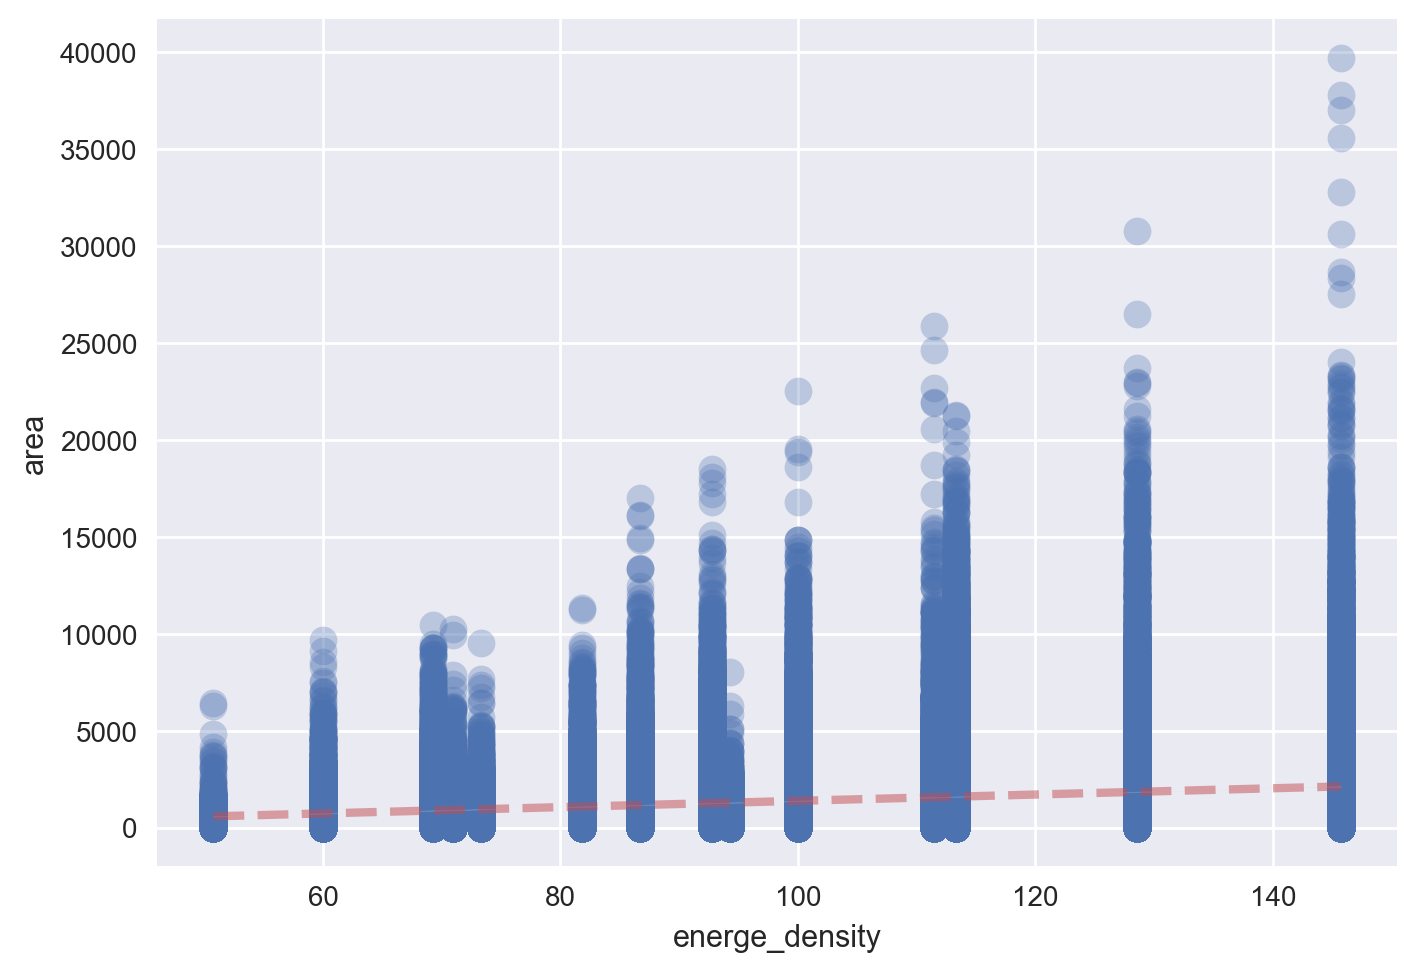

In [46]:
sns.regplot(x="energe_density", y="area", data=merge_data_1,
            scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})

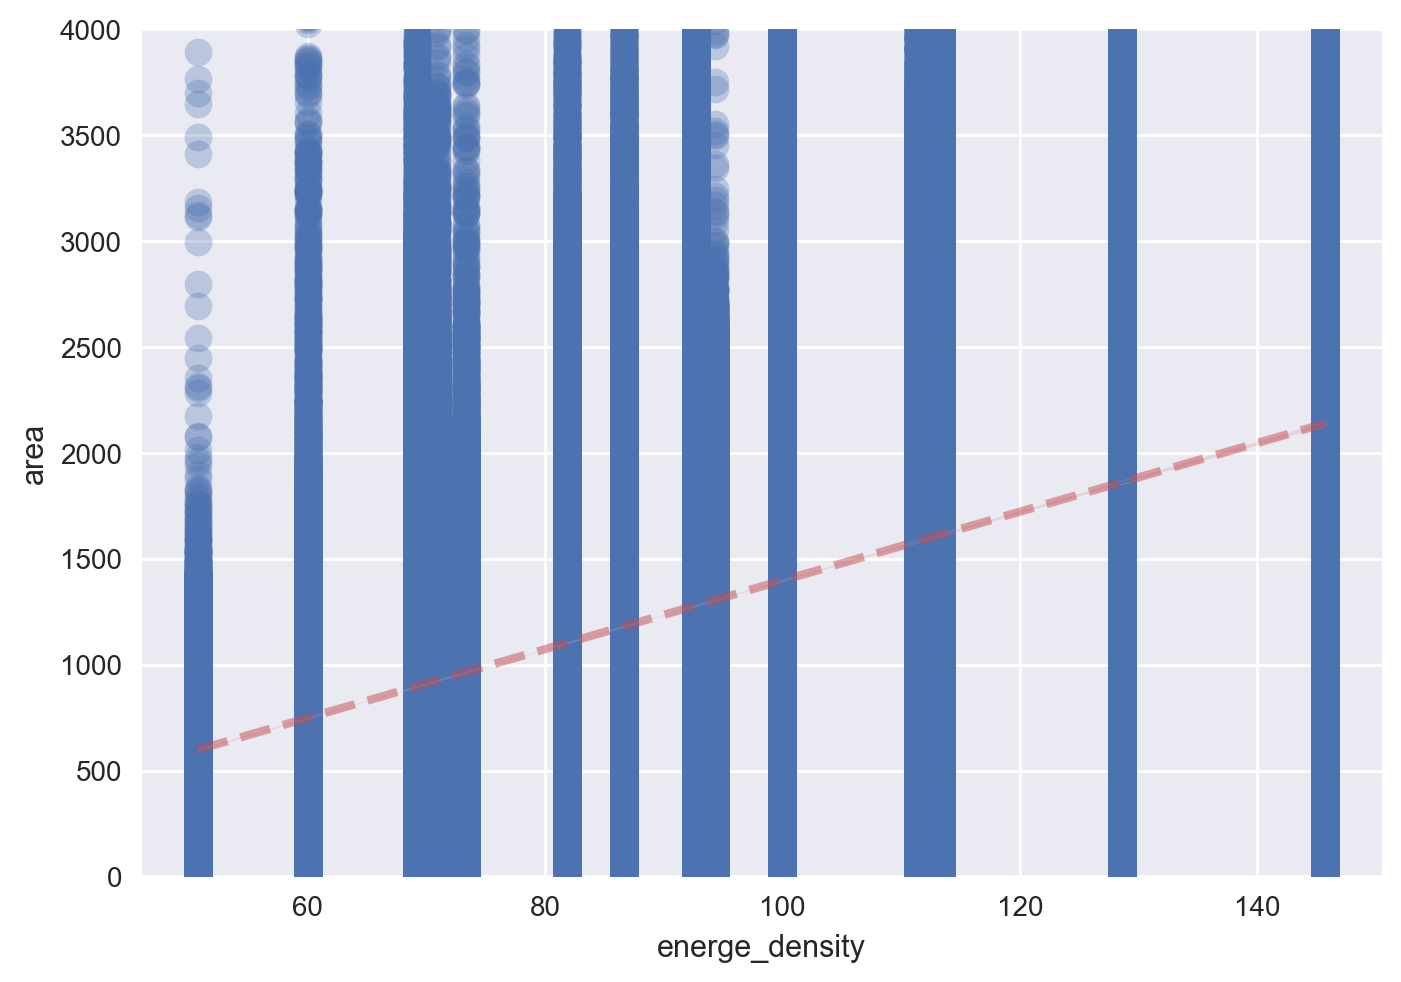

In [47]:
sns.regplot(x="energe_density", y="area", data=merge_data_1,
            scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
plt.ylim(0,4000)
plt.show()

<AxesSubplot: xlabel='lazer_power', ylabel='area'>

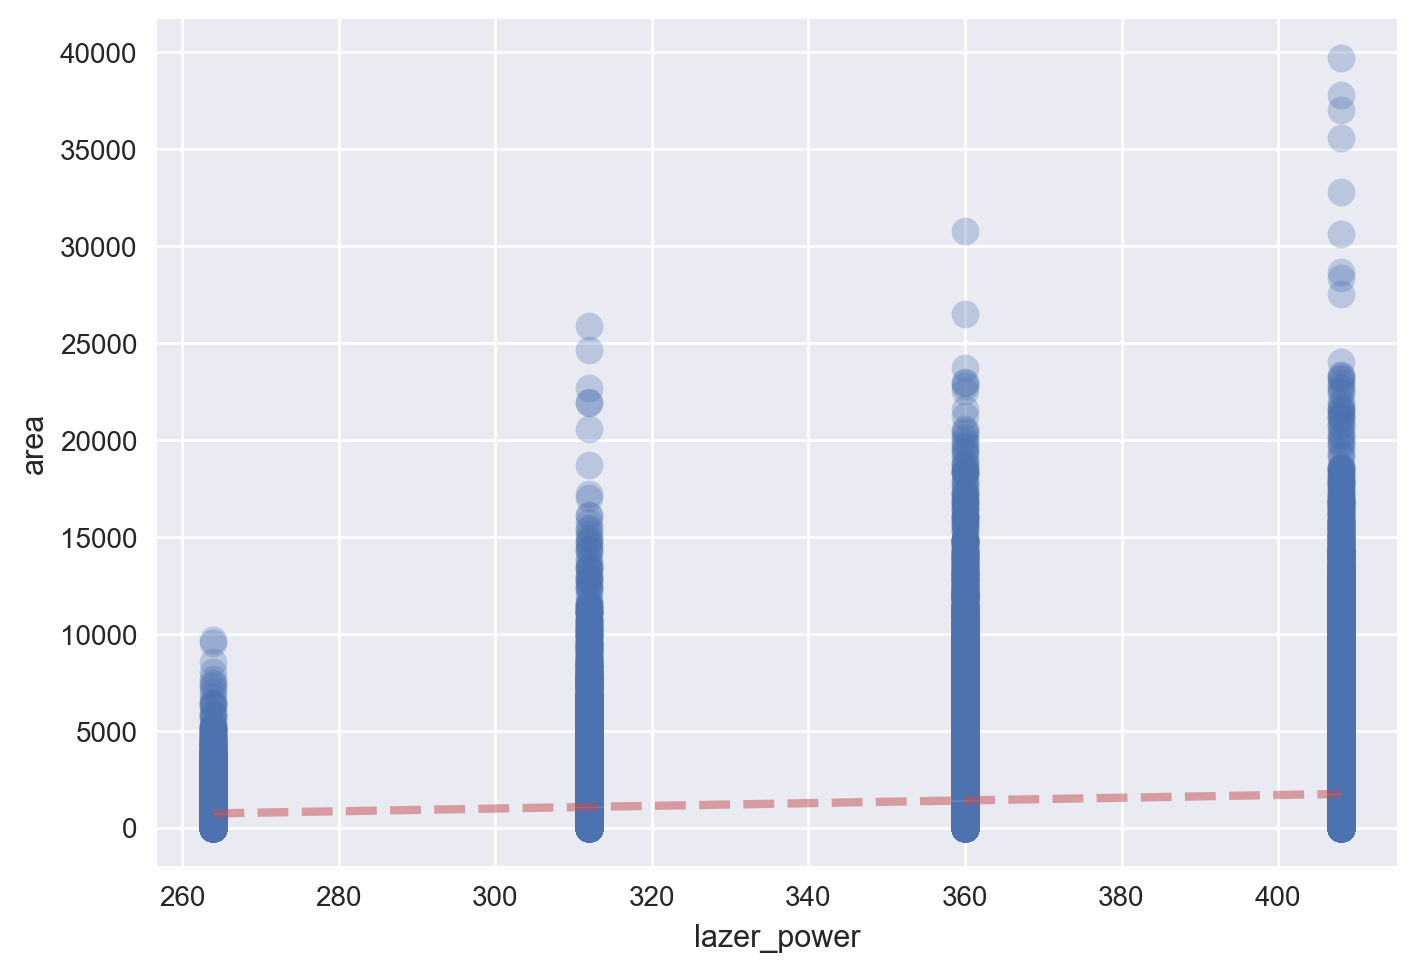

In [54]:
sns.regplot(x="lazer_power", y="area", data=merge_data_1,
            scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})

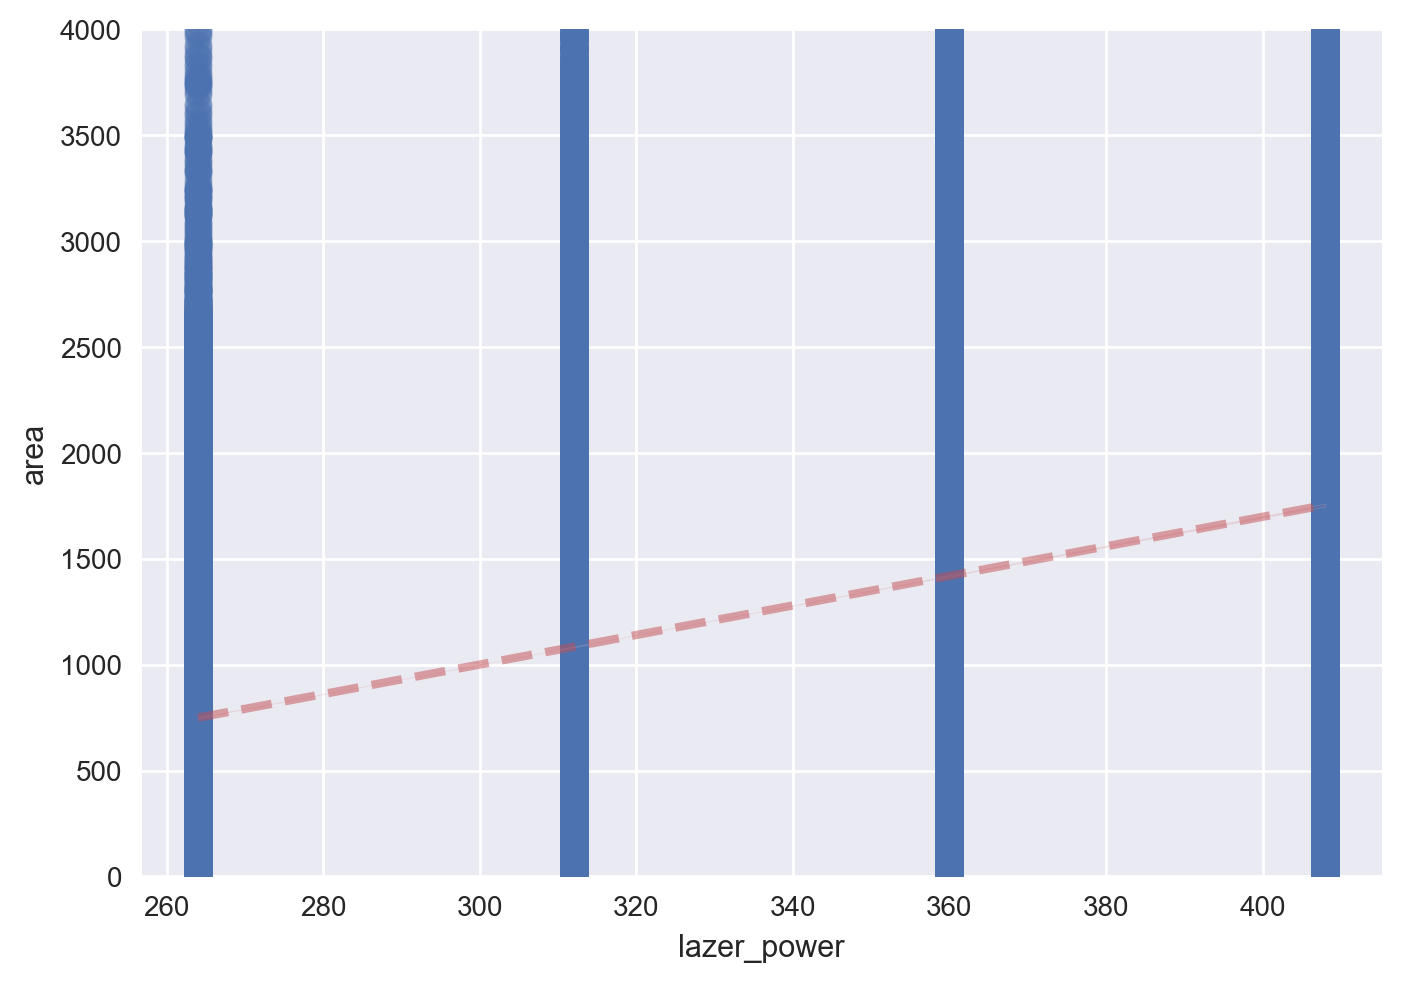

In [48]:
sns.regplot(x="lazer_power", y="area", data=merge_data_1,
            scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
plt.ylim(0,4000)
plt.show()

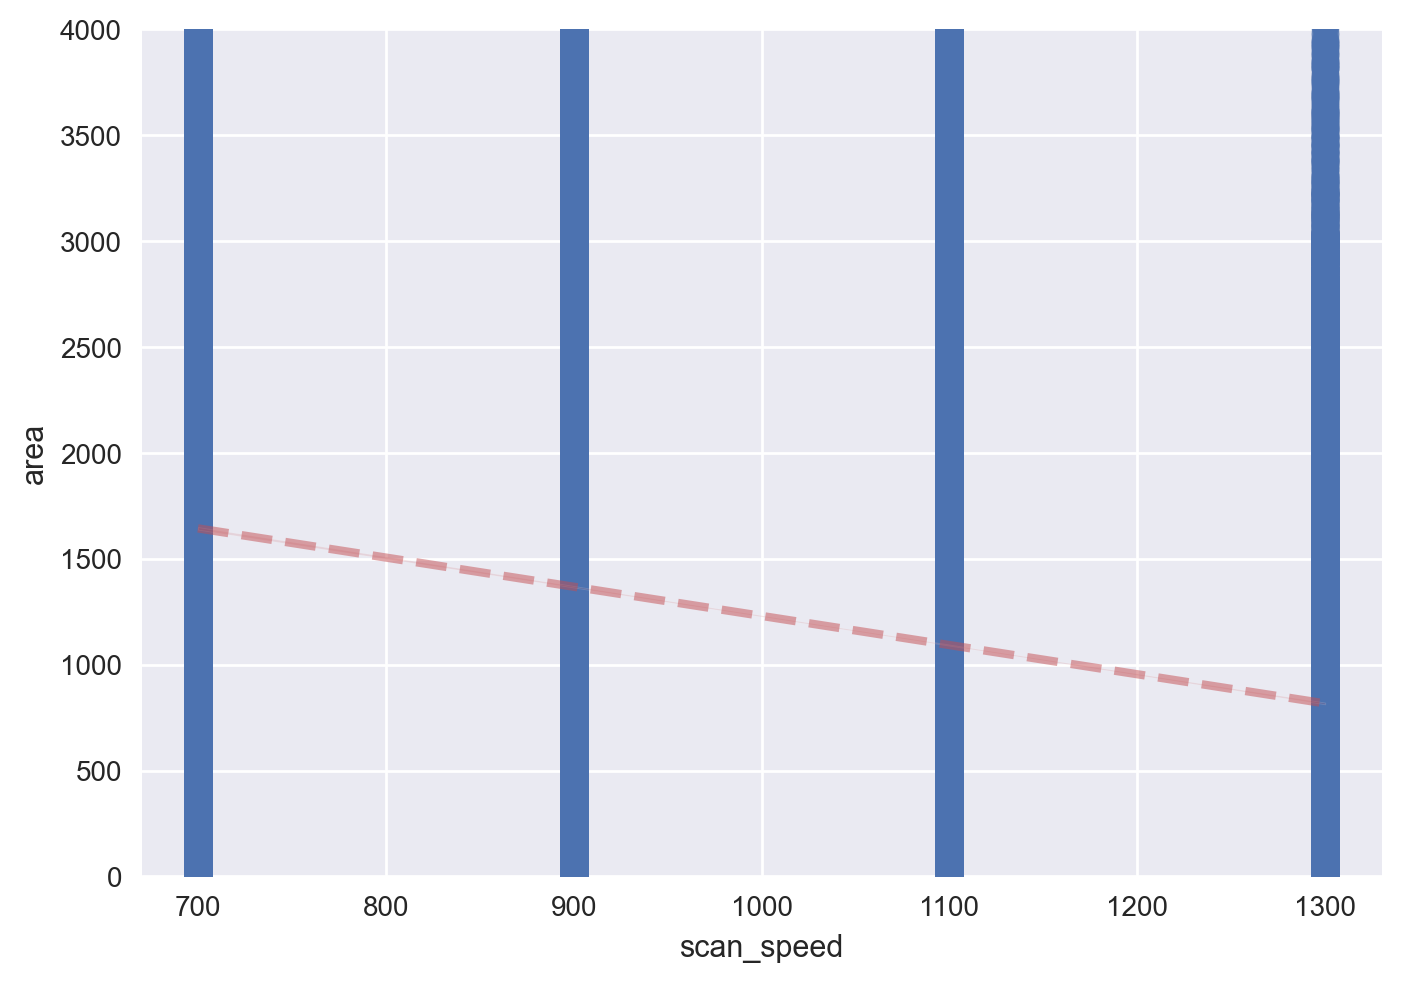

In [49]:
sns.regplot(x="scan_speed", y="area", data=merge_data_1,
            scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
plt.ylim(0,4000)
plt.show()

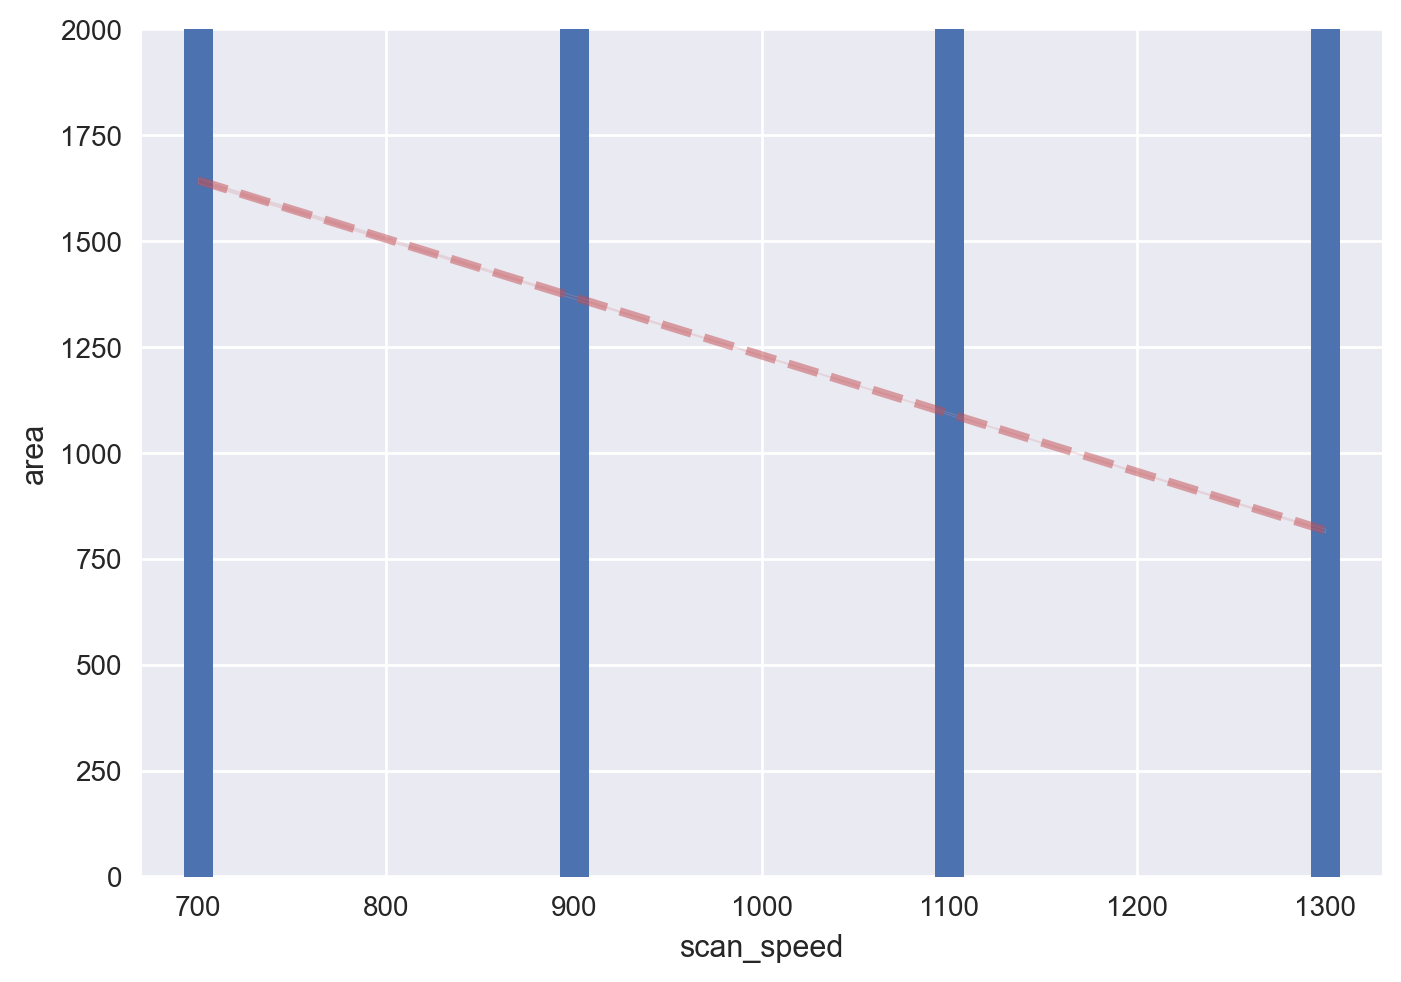

In [50]:
sns.regplot(x="scan_speed", y="area", data=merge_data_1,
            scatter_kws={"fc":"b", "ec":"b", "s":100, "alpha":0.3},
            color="r", line_kws={"lw":3, "ls":"--","alpha":0.5})
plt.ylim(0,2000)
plt.show()